In [1]:
path = './Circadian-zonation/'

In [2]:
dic_struc = ['00A','06A','12A','18A','00B','06B','12B','18B','00C','12C']
rep_1 = ['00A','06A','12A','18A']

In [3]:
l_circadian = ['arntl', 'clock', 'npas2', 'nr1d1', 'nr1d2', 'per1', 'per2', 'cry1', 'cry2', 'dbp', 'tef', 'hlf', 
               'elovl3', 'rora', 'rorc']
l_zonated = ['glul', 'ass1','asl','cyp2f2','cyp1a2','pck1','cyp2e1', 'cdh2','cdh1','cyp7a1','acly', 'alb', "oat", 
             "aldob", 'cps1']

In [4]:
import scipy.io as sio
import numpy as np
import dataset_gen

import torch.nn as nn
import torch.utils.data as torchdata
import torch

import importlib
import sudo_algo2
import encoder
import matplotlib.pyplot as plt;


In [5]:
def reload():
    importlib.reload(encoder)
    importlib.reload(sudo_algo2)
    importlib.reload(dataset_gen)

def dic_to_array(dic, lists_g):
    output = None
    for l in lists_g:
        cell_data = np.vstack([dic[g] for g in l])
        if output is None:
            output = cell_data
        else:
            output = np.vstack((output, cell_data))
    return output


def load_genes(f):
    res = []
    with open(f, 'r') as f:
        lines = f.readlines()
    res = [cur.strip('\n') for cur in lines]
    f.close()
    return res

def add_noise(X, scale):
    m, n = X.shape
    noise = np.random.normal(m, n)
    return X + noise * scale

def plot_vec(l):
    for cur in l:
        plt.plot([i for i in range(len(cur))], cur, '--') 
    plt.grid()

def off_set(X):
    a, b = X.shape
    offset = (10**(-4)) * np.ones((a, b))
    X = X + offset
    return X
def log_output(X):
    return np.log2(X, out=np.zeros_like(X), where=(X!=0))

In [6]:
def get_index_ref_gene(g, gene_list):
    ref = []
    if g == 'z':
        ref = l_zonated 
    else:
        ref = l_circadian
    res = {}
    for cur in ref:
        for i in range(len(gene_list)):
            if gene_list[i] == cur:
                res[cur] = i
    return res 

# load data into a dic from gene to representation of corresponding key 
def load_data_key(key, files):
#     path = '/n/home05/ysheng/Circadian-zonation/'
#     # map gene to cell
#     z_gene = load_genes(path + 'Z_gene.csv')
#     r_gene = load_genes(path + 'R_gene.csv')
#     z_r_gene = load_genes(path + 'Z+R_gene.csv')
#     zxr_gene = load_genes(path + 'ZxR_gene.csv')
    count = 0
    data = {}
#     for f in dic_struc:
    for f in files:
        load_path = path + 'Datasets/Profiles/ZT'+f+'.mat'
        cur_data = sio.loadmat(load_path)
        cur_list = [temp[0].astype(str) for temp in cur_data['all_genes']]
        for i in range(len(cur_list)):
            g = cur_list[i][0].astype(str)
            if (g in z_gene) or (g in r_gene) or (g in z_r_gene) or (g in zxr_gene):
                if g in data:
    #                 print(type(data[g]))
    #                 print(type(cur_data['mat_norm'][i]))
                    data[g] = np.concatenate((data[g], cur_data[key][i]))
                else:
                    data[g] = cur_data[key][i]
            else: 
                if count <= 2000:
                    count += 1
                    if g in data:
                        data[g] = np.concatenate((data[g], cur_data[key][i]))
                    else:
                        data[g] = cur_data[key][i]
    #                 print(type(data[g])
                else:
                    if g in data:
                        data[g] = np.concatenate((data[g], cur_data[key][i]))
    return data

def remove_ref(l):
    res = []
    for g in l:
        if g not in l_zonated and g not in l_circadian:
            res.append(g)
    return res

In [7]:
def remove_0_rows(data):
    index = np.all(data == 0, axis=1)
    print(data[index[0]])
    return data[~index], index 

# output_mat_norm = dic_to_array(data_mat_norm, [r_gene, z_gene[0:600]])
def output_log_norm(output_mat_norm):
    a, b = output_mat_norm.shape
    offset = (10**(-4)) * np.ones((a, b))
    output_mat_norm_log = log_output(output_mat_norm + offset)
    output_mat_norm_log, index = remove_0_rows(output_mat_norm)
    output_mat_norm_log_norm = dataset_gen.normalized_row(output_mat_norm_log)
    return output_mat_norm_log_norm, index

In [45]:
batch_size = 32
device = 'cpu'
def find_last_reconstruction_error(cur_ae, data, cur_weight, prev_weight_cell):
    temp = dataset_gen.cellDataset(data)
    dataset = torchdata.DataLoader(temp, batch_size, shuffle=False)
    diff_list = sudo_algo2.get_diff_matrix(cur_ae, dataset)
    diff = np.concatenate(tuple(diff_list), axis = 0)
    reweight_cell = prev_weight_cell[:, None] * diff
    exp_gene = np.sum(reweight_cell, axis = 0)
    return exp_gene

def get_encoder(cur_ae, data):
    result = []
    temp = dataset_gen.cellDataset(data)
    dataset = torchdata.DataLoader(temp, batch_size, shuffle=False)
    for x, index in dataset:
        x = x.to(device)
        # print(index)
        code, output = cur_ae(x.float())
#         print(code.shape)
        for c in code:
#             print(c)
            result.append(c.cpu().detach().numpy())
    return result

def get_output(cur_ae, data):
    result = []
    temp = dataset_gen.cellDataset(data)
    dataset = torchdata.DataLoader(temp, batch_size, shuffle=False)
    for x, index in dataset:
        x = x.to(device)
        code, output = cur_ae(x.float())
#         print(output.shape)
        for c in output:
#             print(c)
            result.append(c.cpu().detach().numpy())
    return result
def get_reconstruct(cur_ae, data):
    result = []
    temp = dataset_gen.cellDataset(data)
    dataset = torchdata.DataLoader(temp, batch_size, shuffle=False)
    for x, index in dataset:
        x = x.to(device)
        # print(index)
        code, output = cur_ae(x.float())
#         for c in output:
#             print(c)
        result.append((output - x.float()).cpu().detach().numpy())
    return result

def get_diff_matrix(cur_ae, data):
    temp = dataset_gen.cellDataset(data)
    dataset = torchdata.DataLoader(temp, batch_size, shuffle=False)
    diff_list = sudo_algo2.get_diff_matrix(cur_ae, dataset)
#     print(len(diff_list[0]))
    diff = np.concatenate(tuple(diff_list), axis = 0)
    return diff

In [9]:
def partial_average(g, codes):
    res = []
    for i in range(8):
        subset = [codes > i * 1/8][0] * [codes <= (i + 1) * 1/8][0]
#         print(subset)
        cur = np.sum(np.array(g)[subset])
        res.append(cur * 1/np.sum(subset))
    return res

def shift(g, i):
    ma=  np.max(g)
    mi = np.min(g)
    if (ma - mi) != 0:
        return [(cur - mi)/(ma - mi) for cur in g]
    else:
        return [0]*len(g)

In [10]:
def random_partition(l):
    index = [i for i in range(len(l))] 
    np.random.shuffle(index)
    num_partition = int(len(l)/200)

    part_index = []
    for i in range(num_partition):
        upper = (i + 1) * 200
        if i == num_partition:
            upper = len(index)
        part_index.append(index[i * 200: upper])
    
#     part_index = [index[i * 400: np.min((i + 1) * 400, len(l) - 1)] for i in range(num_partition)]
    return part_index

In [11]:
# get all genes thats classified by CZViz

z_gene = load_genes(path + 'Z_gene.csv')
r_gene = load_genes(path + 'R_gene.csv')
z_r_gene = load_genes(path + 'Z+R_gene.csv')
zxr_gene = load_genes(path + 'ZxR_gene.csv')

In [12]:
data_mat_norm = load_data_key('mat_norm', ['00A', '00B'])

In [22]:
data_mean_gene_exp = load_data_key('MeanGeneExp', ['00A','06A','12A','18A'])

In [14]:
data_mat_norm_total = load_data_key('mat_norm', dic_struc)

In [15]:
total_gene = data_mat_norm_total.keys()
print(len(total_gene))


other_gene = list(((set(total_gene).difference(set(r_gene))).difference(z_r_gene)).difference(z_gene).difference(zxr_gene))

print(len(other_gene))

6773
2001


In [64]:
total_gene = z_gene + r_gene + z_r_gene + zxr_gene 
print(len(total_gene))

4772


In [178]:
partition = random_partition(z_gene + r_gene)

In [18]:
label = [g for g in l_zonated if g in z_gene]
labelr = [g for g in l_circadian if g in r_gene]
print(labelr)

['npas2', 'nr1d2', 'per2']


In [15]:
# check data keys 
f = '12A'
load_path = path + 'Datasets/Profiles/ZT'+f+'.mat'
cur_data = sio.loadmat(load_path)
print(cur_data['seq_data'].shape)
print(cur_data['mat_norm'].shape)

print(cur_data['MeanGeneExp'].shape)
print(cur_data['SE'].shape)
print(type(cur_data['mat_norm'][0]))

test = cur_data['mat_norm'][1100]
pmat = np.array(cur_data['Pmat'])
res = np.matmul(test, pmat)
# print(res)

print(res - cur_data['MeanGeneExp'][1100])
# print(cur_data['Pmat'][1])

(14812, 710)
(14812, 710)
(14812, 8)
(14812, 8)
<class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
#  8 layers, each layer has a distribution over cells
print(pmat.shape)
print(np.linalg.norm(pmat, 1, axis = 0))

(710, 8)
[1. 1. 1. 1. 1. 1. 1. 1.]


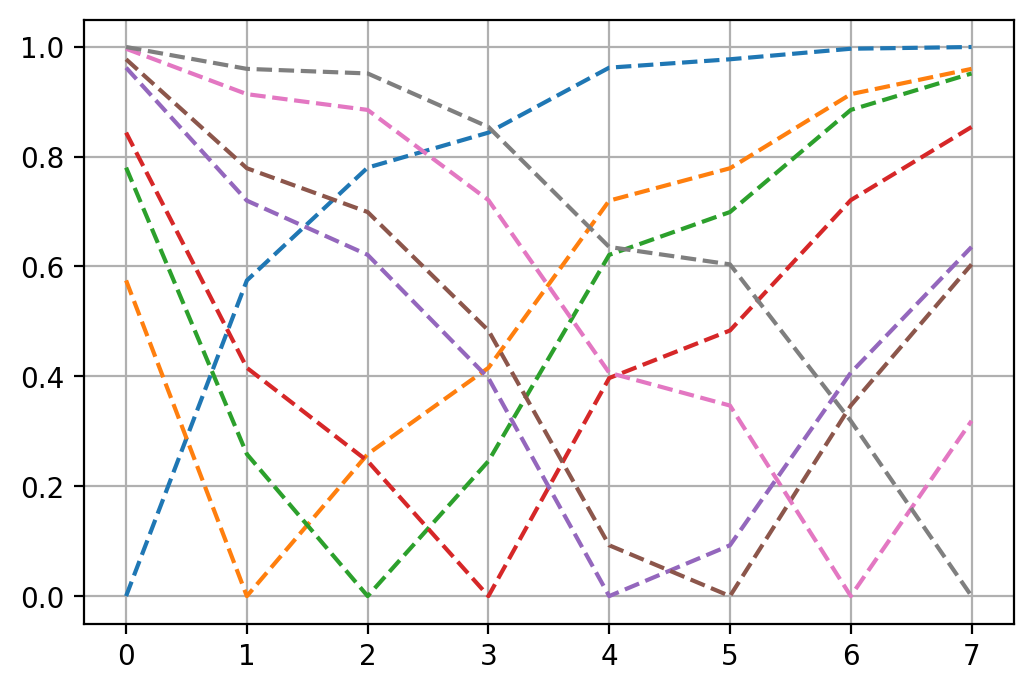

In [16]:
# Compute matrix of total variational distance
M = np.zeros((8, 8))
for i in range(8):
    for j in range(8):
        M[i][j] = 0.5 * np.linalg.norm(pmat[:, i] - pmat[:, j], 1)
plot_vec([M[i, :] for i in range(8)])

In [113]:
#computed variance of each layer 
# print(len(pmat[:, 0]))
# for i in range(8):
#     print(np.var(cur_data['mat_norm'] * pmat[:, i]))
# print(np.var(cur_data['mat_norm']))
# for i in range(8):
#     print(np.var(pmat[:, i]))
g = 10
for i in range(8):
    print(np.sum((cur_data['mat_norm'][g] - [np.sum(cur_data['mat_norm'][g] * pmat[:, i])] * len(cur_data['mat_norm'][g]))**2 * pmat[:, i]))
print(np.var(cur_data['mat_norm'][g]))

2.680416427431754e-08
2.3464258632328962e-08
2.4645202484895397e-08
2.522038941094107e-08
2.7198228918400267e-08
2.719844083461372e-08
3.034793001973592e-08
3.855211993300006e-08
2.7003086330656723e-08


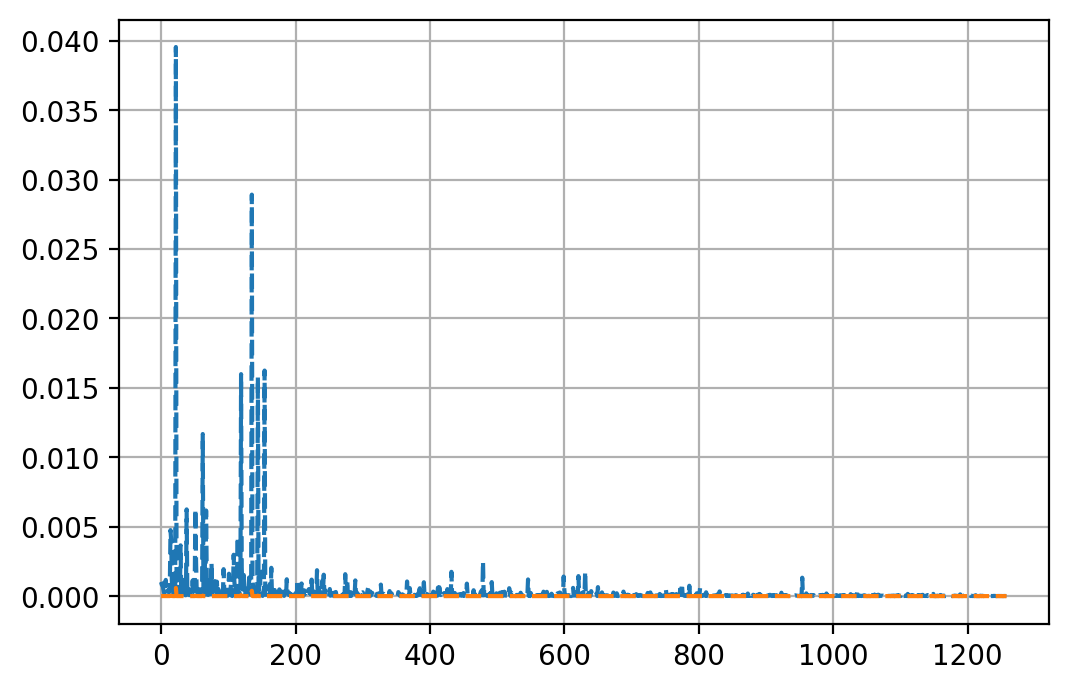

In [60]:
plot_vec([[np.mean(data_mat_norm[z_gene[i]]) for i in range(len(z_gene))], [np.var(data_mat_norm[z_gene[i]]) for i in range(len(z_gene))]])

In [75]:
# find the smallest positive value
np.min([np.where(data_mat_norm[g] > 0, data_mat_norm[g], np.inf).min() for g in total_gene])

5.749221818873859e-06

32
2.7916172696010657e-08


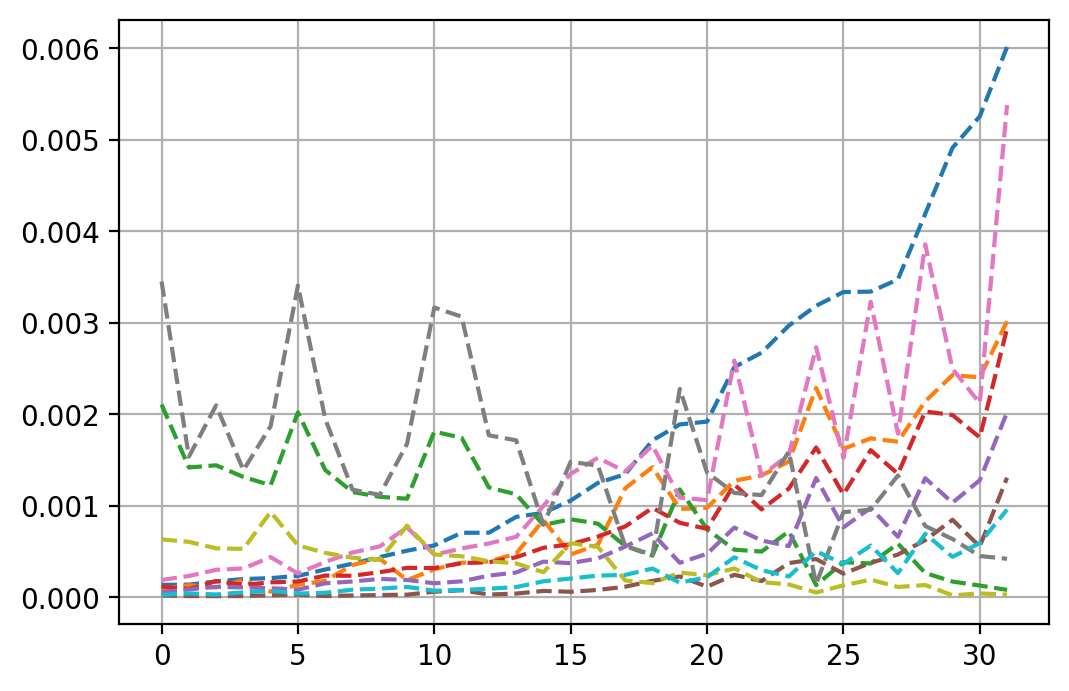

In [23]:
# check average value of z_gene for rat A at all 4 time points
# ordered by argsort of the 1st z_gene
order2 = np.argsort(data_mean_gene_exp[z_gene[0]])
print(len(order2))
print(np.min([np.min(data_mean_gene_exp[z_gene[i]]) for i in range(50)]))
plot_vec(data_mean_gene_exp[z_gene[i]][order2] for i in range(10))

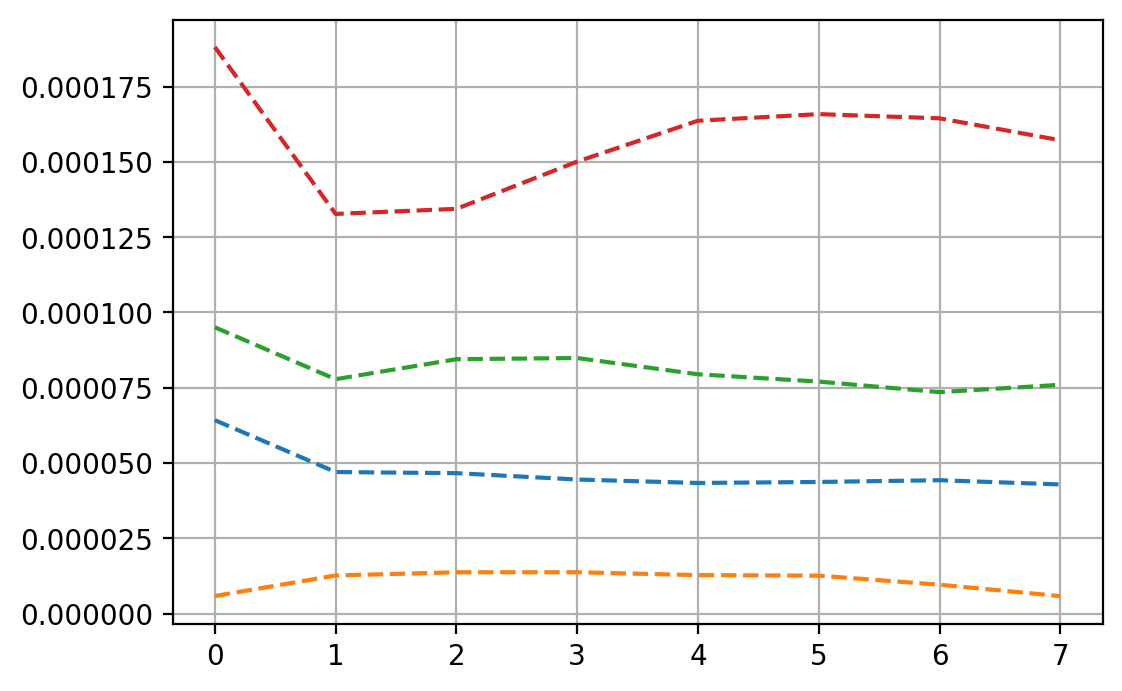

In [28]:
# check expression of r gene at different times
plot_vec([data_mean_gene_exp[r_gene[3]][8*i: 8*(i + 1)] for i in range(4)])

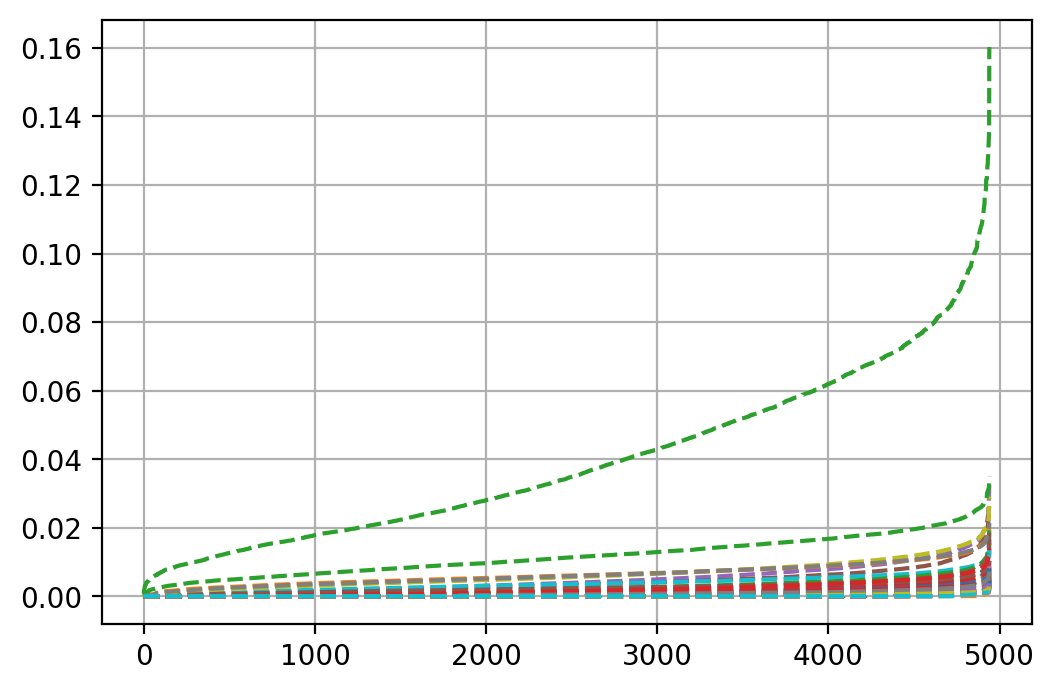

In [30]:
# check expression level of some genes 
plot_vec([data_mat_norm[z_gene[i]][np.argsort(data_mat_norm[z_gene[i]])] for i in range(100)])

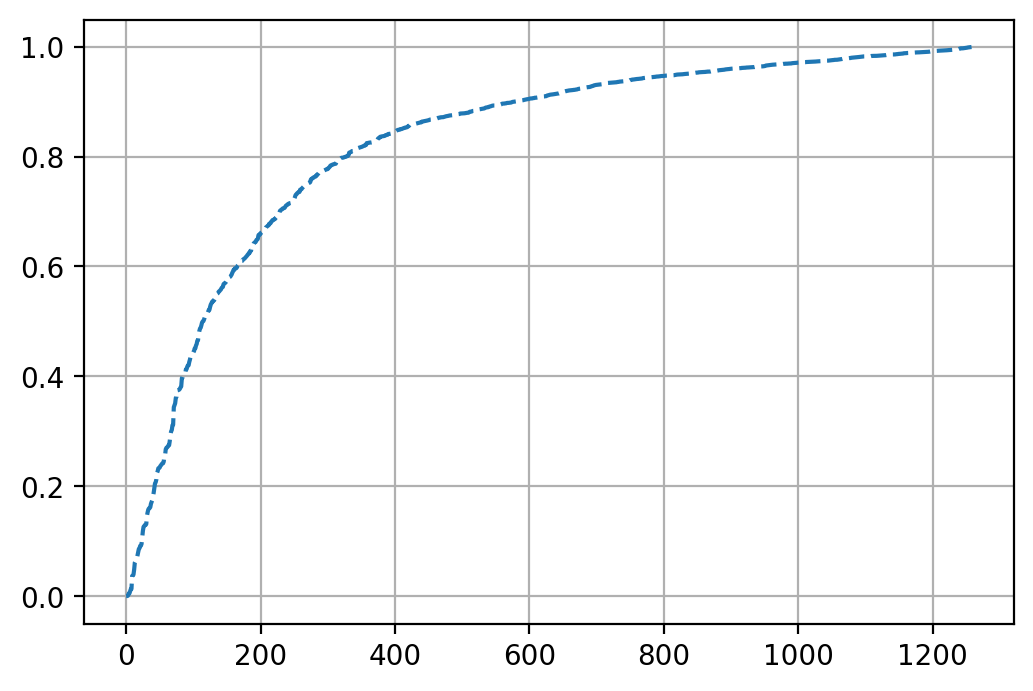

In [31]:
# check number of cells with value 0 outfor each gene 
num_min = {}
for i in range(len(z_gene)):
    m = np.min(data_mat_norm_total[z_gene[i]])
#     print(m)
    if m == 0:
        num_min[z_gene[i]] = (len(np.where(data_mat_norm_total[z_gene[i]] == m)[0]) / len(data_mat_norm_total[z_gene[i]] ))
plot_vec([np.sort([num_min[g] for g in z_gene])])

In [32]:
# test on data from 00A and 00B
reload()
data1 = {}
for g in z_gene:
#     print(g)
    temp = data_mat_norm[g] + np.array([1e-07] * len(data_mat_norm[g]))
    data1[g] = np.log2(np.array(temp))
    data1[g] = np.array(shift(data1[g], g))
#     print(len(data1[g])) 
#     if np.all([np.array(data1[g]) == 0]):
#         print(g)
#     else:
#         data1[g] = dataset_gen.normalized_row_nan(np.array([data1[g]]))[0]

#     temp = np.array(shift(data_mat_norm[g], g)) + np.array([1e-04] * len(data_mat_norm[g]))
#     data1[g] = np.log2(np.array(temp)) - np.array([np.log2(11e-5)] * len(data_mat_norm[g]))
    

# order1 = np.argsort(np.log2(data_mat_norm[z_gene[0]]))
# plot_vec([np.log2(data_mat_norm[l_zonated[i]])[order1] for i in range(1)])

for g in r_gene:
#     print(g)
    temp = data_mat_norm[g] + np.array([1e-07] * len(data_mat_norm[g]))
    data1[g] = np.log2(np.array(temp))
    data1[g] = np.array(shift(data1[g], g))
#     if np.all([np.array(data1[g]) == 0]):
#         print(g)
#     else:
#         data1[g] = dataset_gen.normalized_row_nan(np.array([data1[g]]))[0]
#     print(len(data1[g]))
#     temp = np.array(shift(data_mat_norm[g], g)) + np.array([1e-04] * len(data_mat_norm[g]))
#     data1[g] = np.log2(np.array(temp)) - np.array([np.log2(11e-5)] * len(data_mat_norm[g]))

In [43]:
print(np.min([np.where(data_mat_norm[g] > 0, data_mat_norm[g], np.inf).min() for g in z_gene + r_gene]))

1.2297685339125354e-05


/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


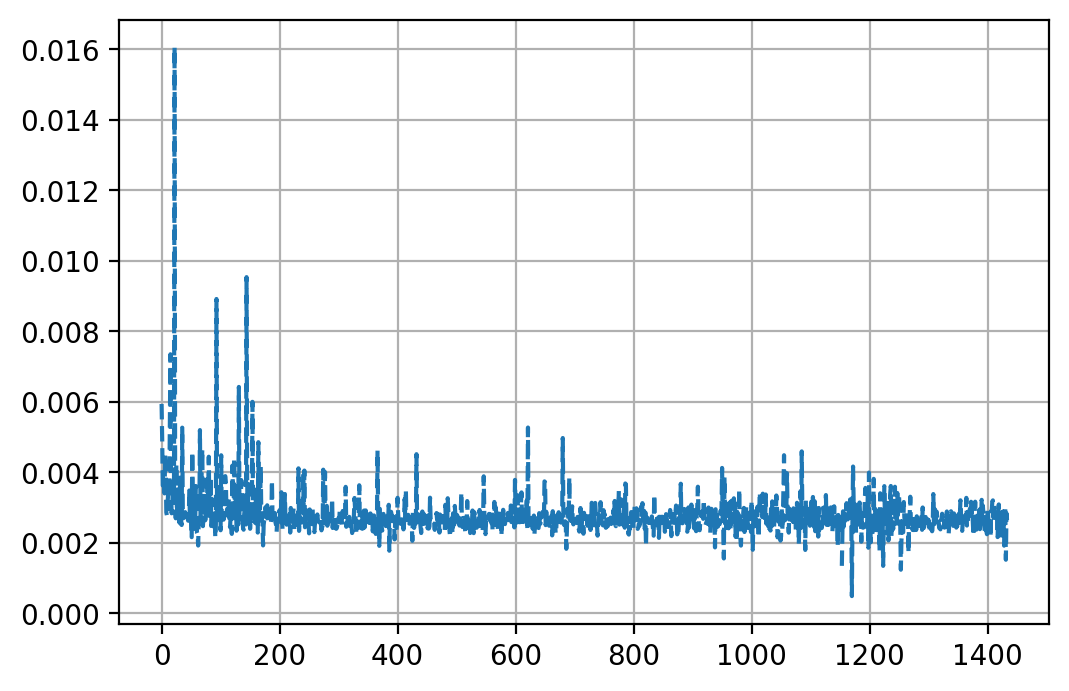

In [33]:
# plot variance of each gen
plot_vec([[np.var(data1[g][data1[g] != 0]) for g in z_gene + r_gene]])

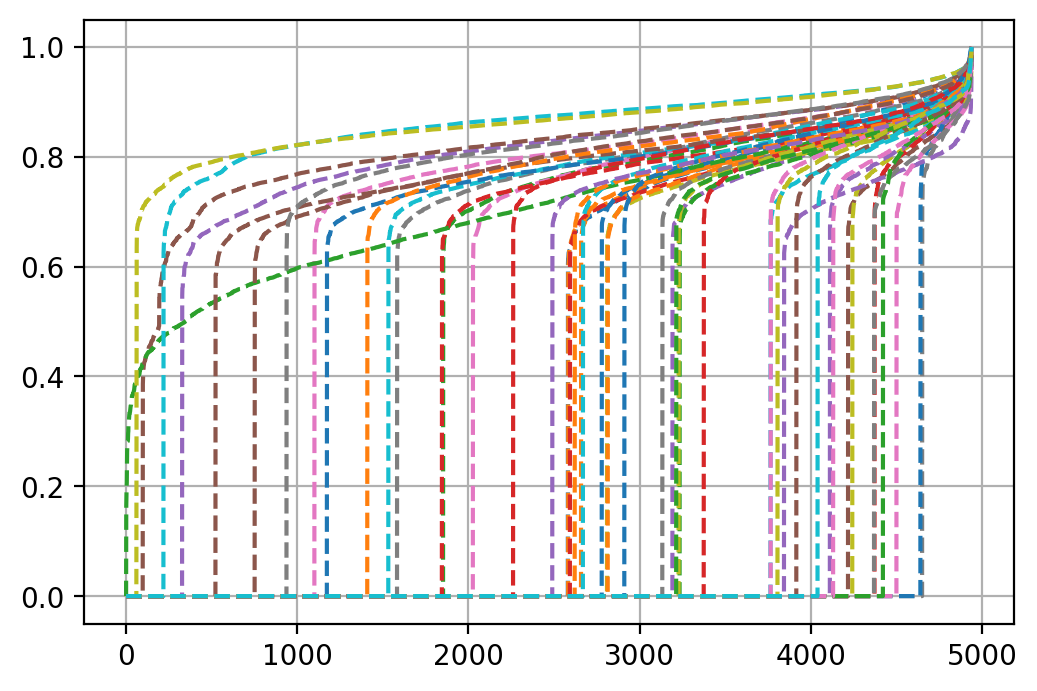

In [38]:
# plot some z_genes after preprocessing
plot_vec([data1[z_gene[i]][np.argsort(data1[z_gene[i]])] for i in range(50)])

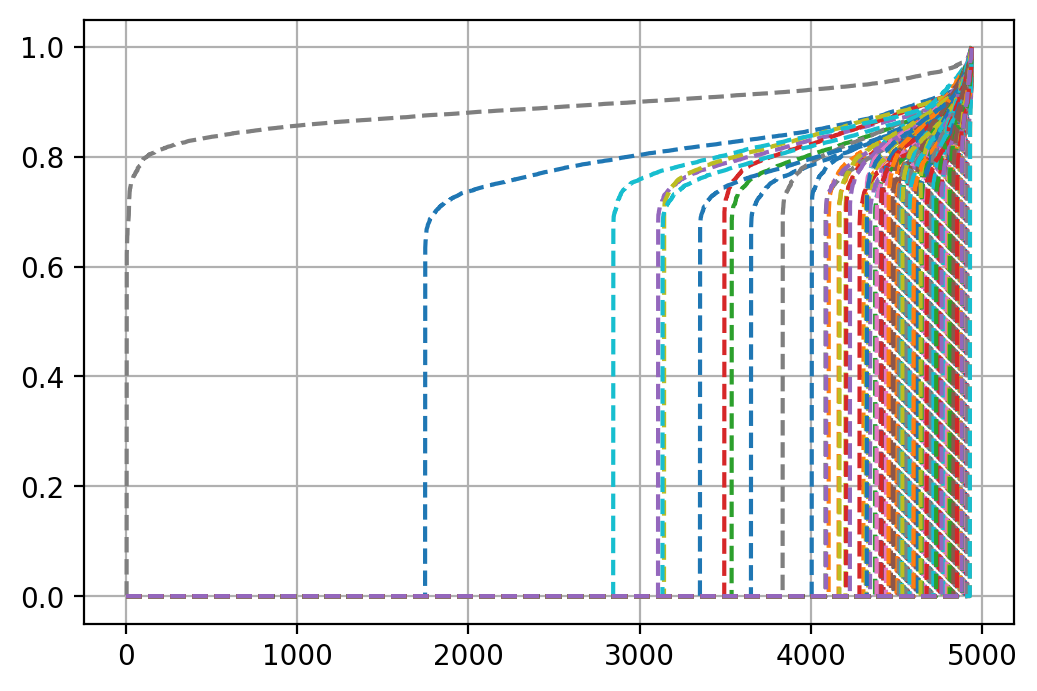

In [39]:
# plot some r_genes after preprocessing
plot_vec([data1[r_gene[i]][np.argsort(data1[r_gene[i]])] for i in range(175)])
# plot_vec([data1[r_gene[i]][order0] for i in range(175)])
# plot_vec([data1[g] for g in r_gene[0:1]])

In [179]:
# one gene that's just 0
print(data_mean_gene_exp['rapgef4os1'] )

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


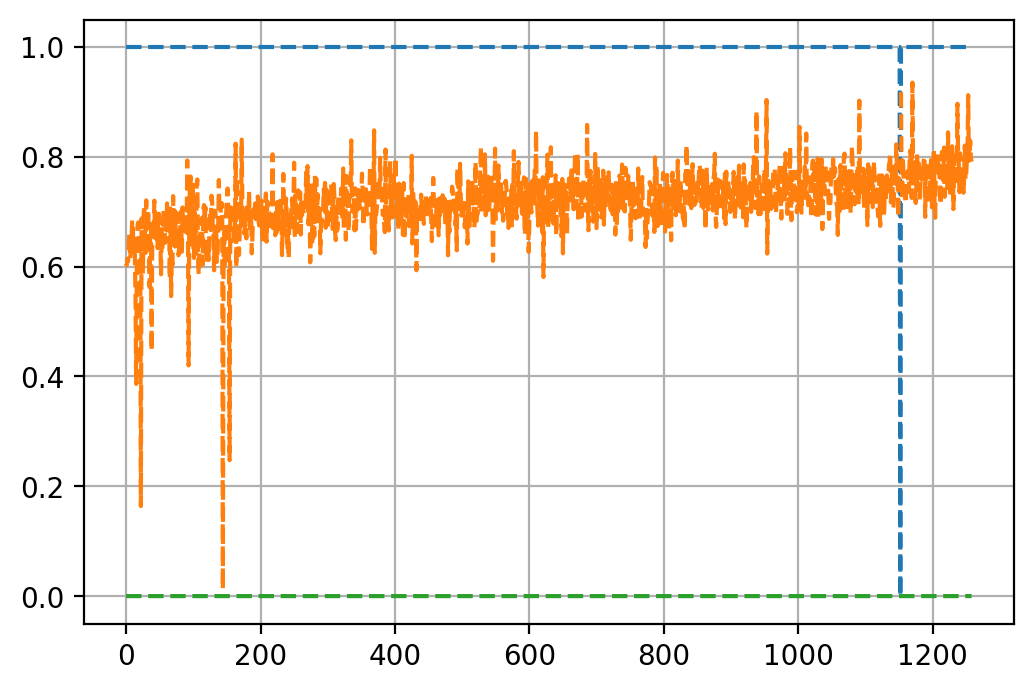

In [41]:
# check the max and min values of z_genes after shifting
plot_vec([[np.max(data1[g]) for g in z_gene], [np.where(data1[g] > 0, data1[g], np.inf).min() for g in z_gene], [np.min(data1[g]) for g in z_gene]])

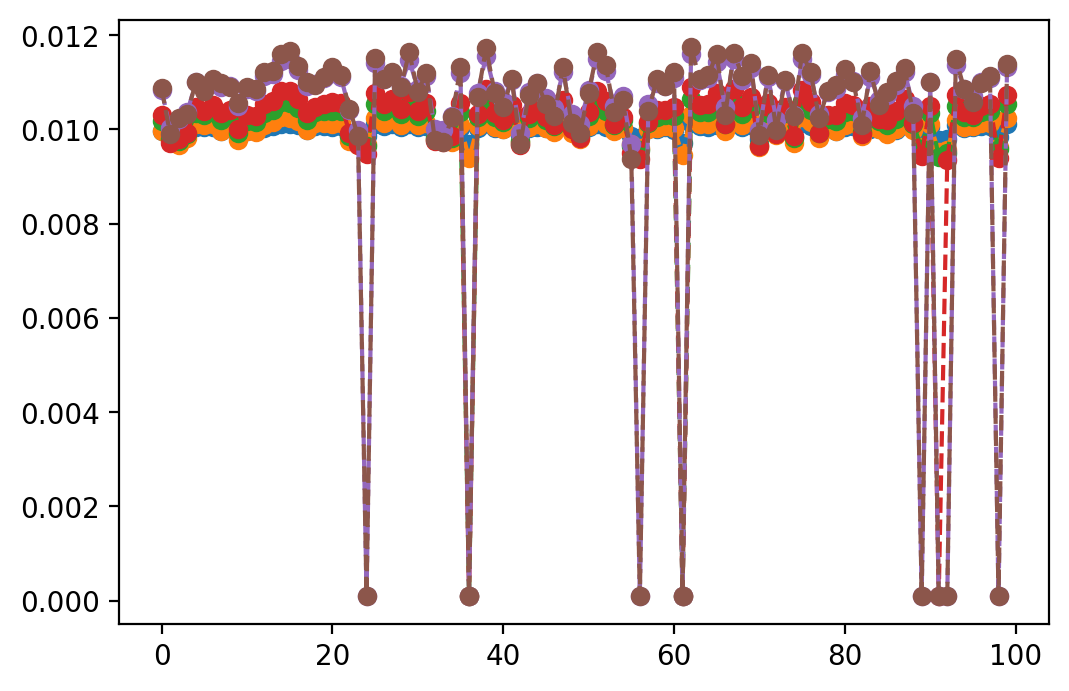

1.0000000000000002


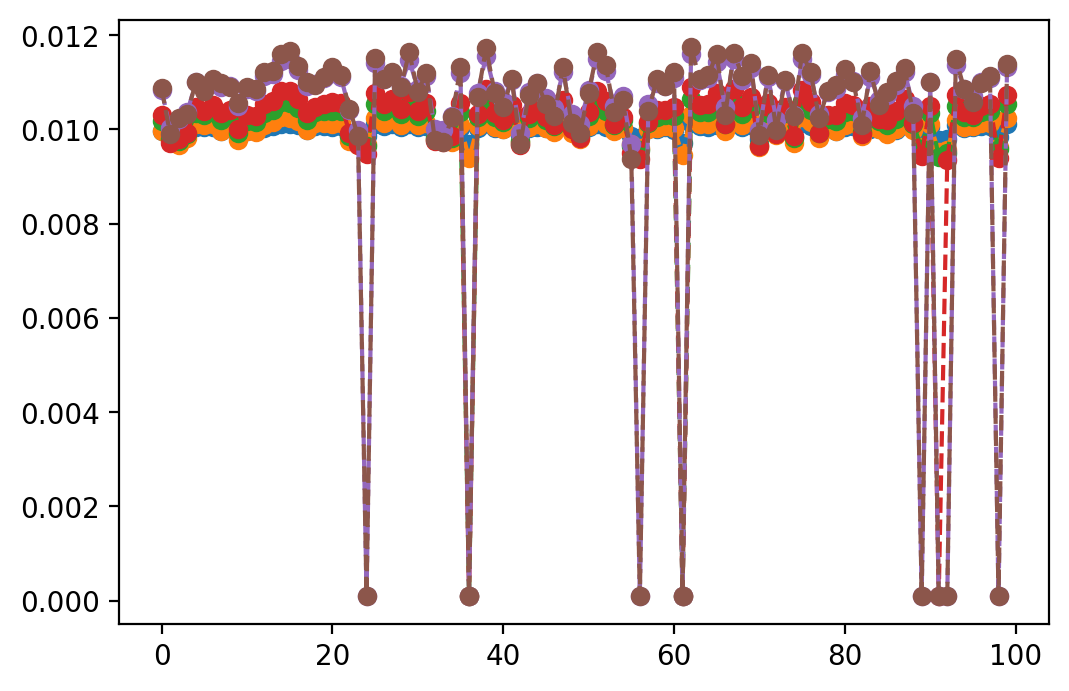

In [54]:
reload()
output_mat = dic_to_array(data1, [z_gene[0:100]])
# output_mat = dataset_gen.normalized_row_nan(output_mat)
# output_mat_norm_log_norm = dataset_gen.normalized_row(output_mat).T
# output_mat_norm_log_norm = output_mat.T
# print([index == True])
data_dim, cell_dim = output_mat.shape
max_epoch = 200
code_dim = 1
hidden_layers = [64]
# hidden_layers = [16, 8]
step_size = 0.05
num_iter = 5
train_len = int(cell_dim * 0.98)
print(cell_dim)
print(train_len)
init_weight = 1 * np.array([1/data_dim]*data_dim) + 0 * np.array(([1/len(l_zonated)]*len(l_zonated) + [0] * (data_dim - len(l_zonated))))
init_cell_weight = np.array([1/train_len]*train_len)

algo_output8 = sudo_algo2.multi_weight_weightedMSE(output_mat, data_dim, max_epoch, code_dim, hidden_layers, step_size, num_iter, init_weight,init_cell_weight, True)




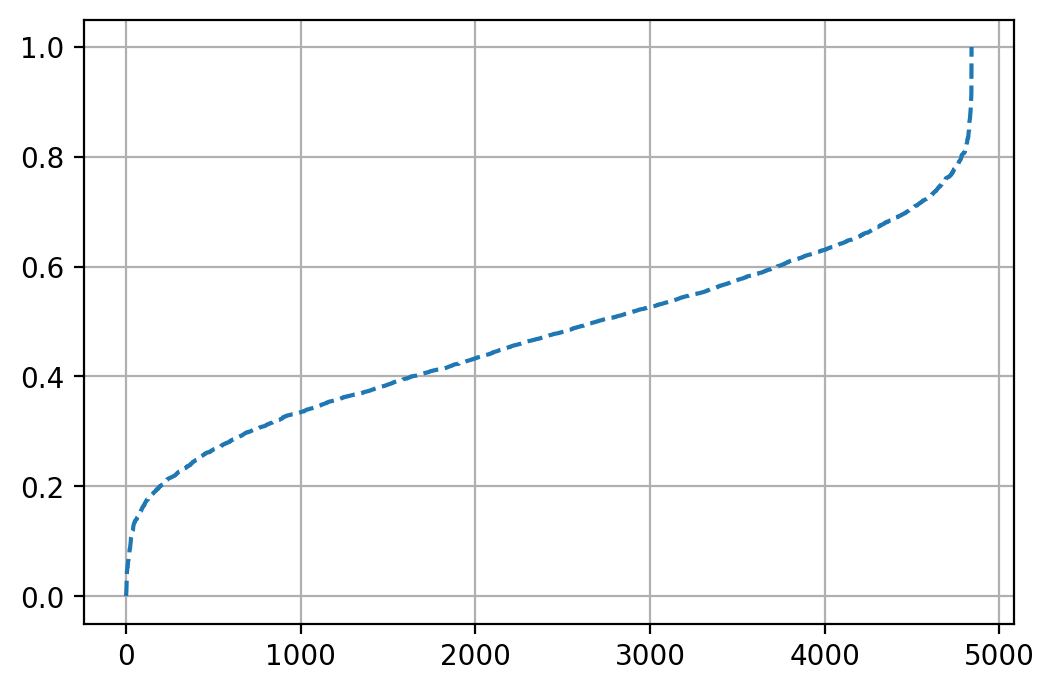

In [55]:
# check sorted codes 
shifted_codes = shift(codes, 'none')
plot_vec([np.sort(np.array(shifted_codes).T)[0]])

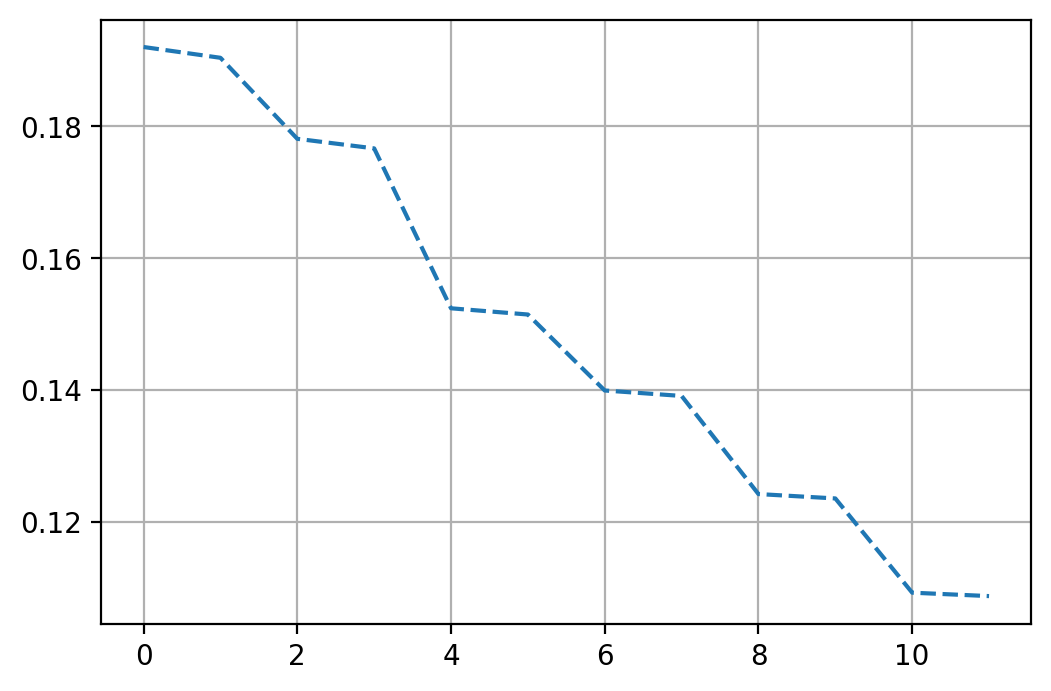

In [43]:
plot_vec([algo_output8[3]])

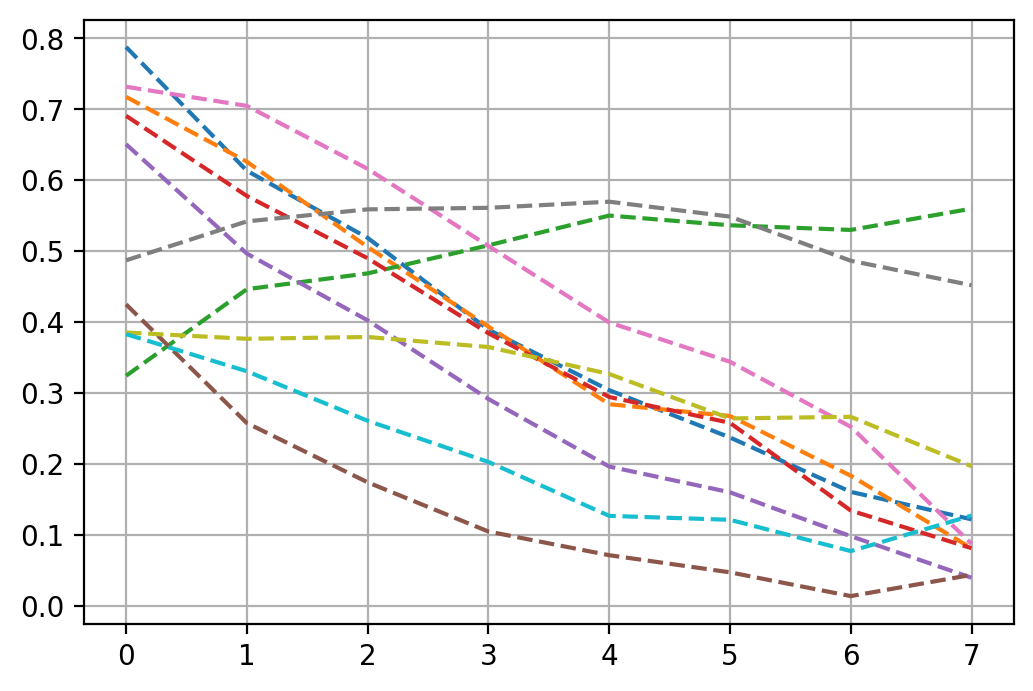

In [56]:
# attempt to find average value for each of the 8 layers for original data
output_mat = dic_to_array(data1, [z_gene[0:100]])
codes = get_encoder(algo_output8[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in z_gene[0:10]:
    res.append(partial_average(data1[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)


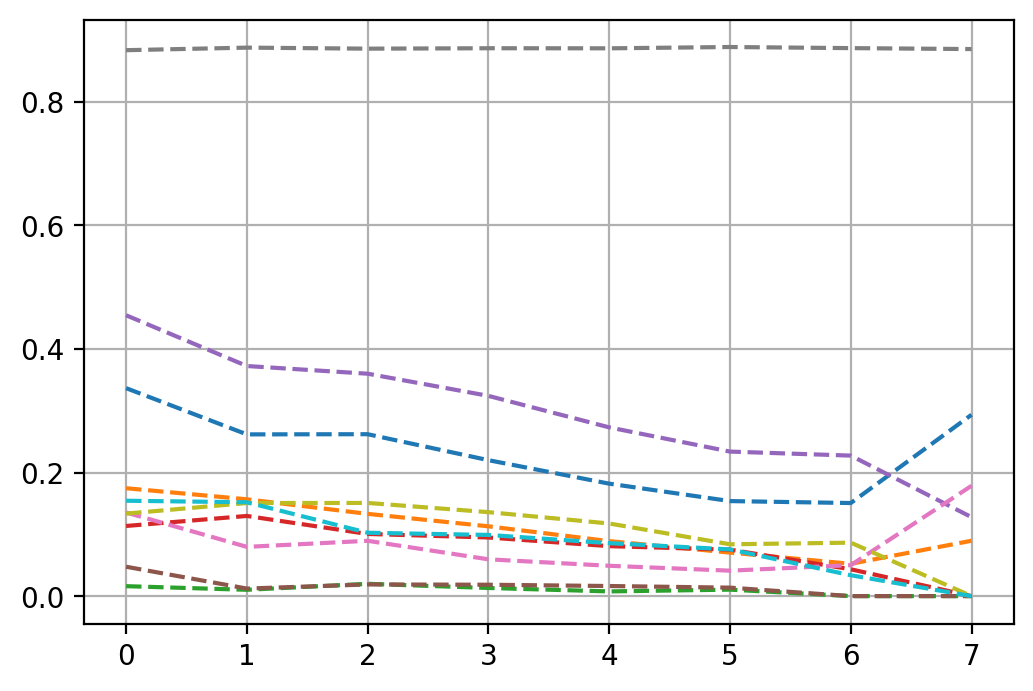

In [57]:
# attempt to find average value for each of the 8 layers for original data for r_gene
output_mat = dic_to_array(data1, [z_gene[0:100]])
codes = get_encoder(algo_output8[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in r_gene[0:10]:
    res.append(partial_average(data1[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

(4842,)


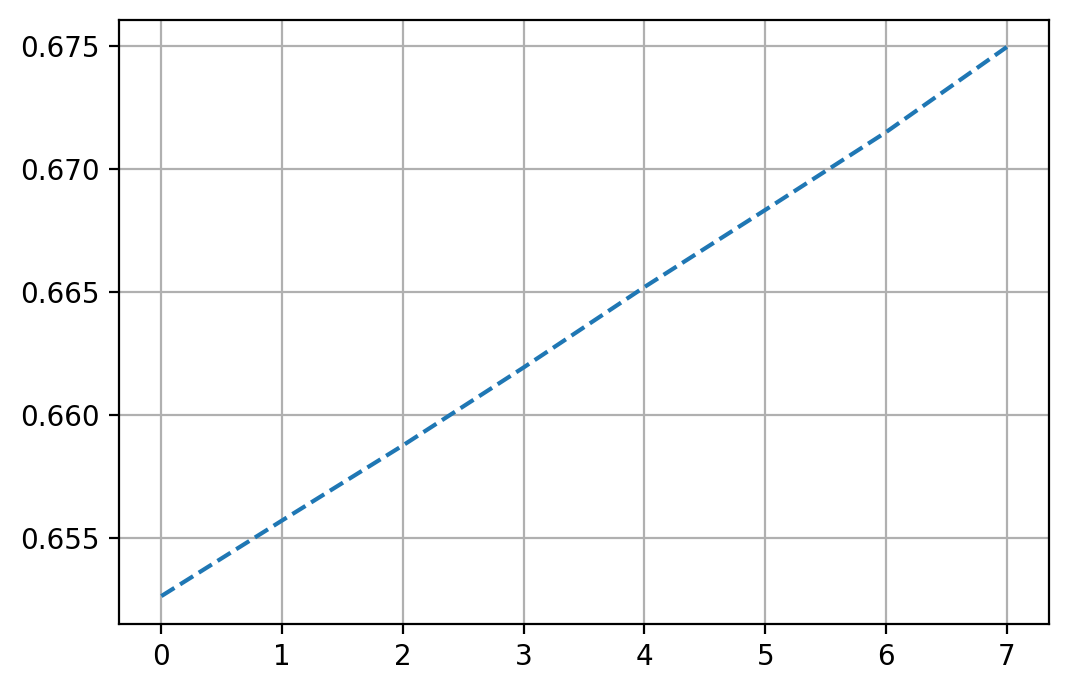

In [58]:
# plot average of reconstruction for some genes based on encoding of cells
# [np.where(data1[g][0] > -22, data1[g][0], np.inf).min() for g in z_gene]
outputs = np.array(get_output(algo_output8[0], output_mat[:, 0:train_len]))
print(outputs[:, 0].shape)
res = []
for i in [0]:
#     res.append(data1[z_gene[i]])
    res.append(partial_average(outputs[:, i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

In [202]:
# check variance of gene expressions after averaging based on cell position
var = [np.var(partial_average(data1[i][0:train_len], np.array(shifted_codes).T[0])) for i in z_gene[0:10] + r_gene[0:10]]
print(var)

[0.04275593529482112, 0.03260101290953515, 0.04259028358978731, 0.022671973767174, 0.007831860922791225, 0.004354266313879532, 0.016166695893512776, 0.06379600148187034, 0.05731479830684778, 0.006832159102922213, 0.004063280825759434, 0.0004023251267049856, 2.1643180752239303e-05, 0.001072531990788151, 0.009935424543902498, 4.700570455546033e-05, 0.00029357695973394025, 3.081175321940368e-05, 0.0006305018389543685, 0.0010385362548129859]


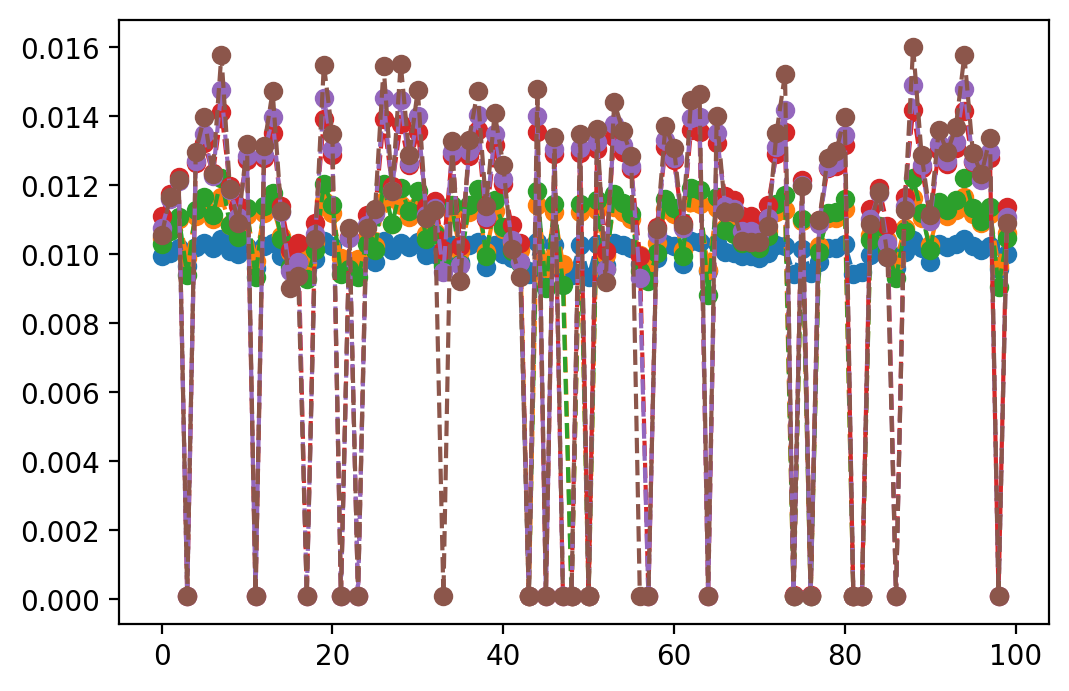

0.9999999999999998


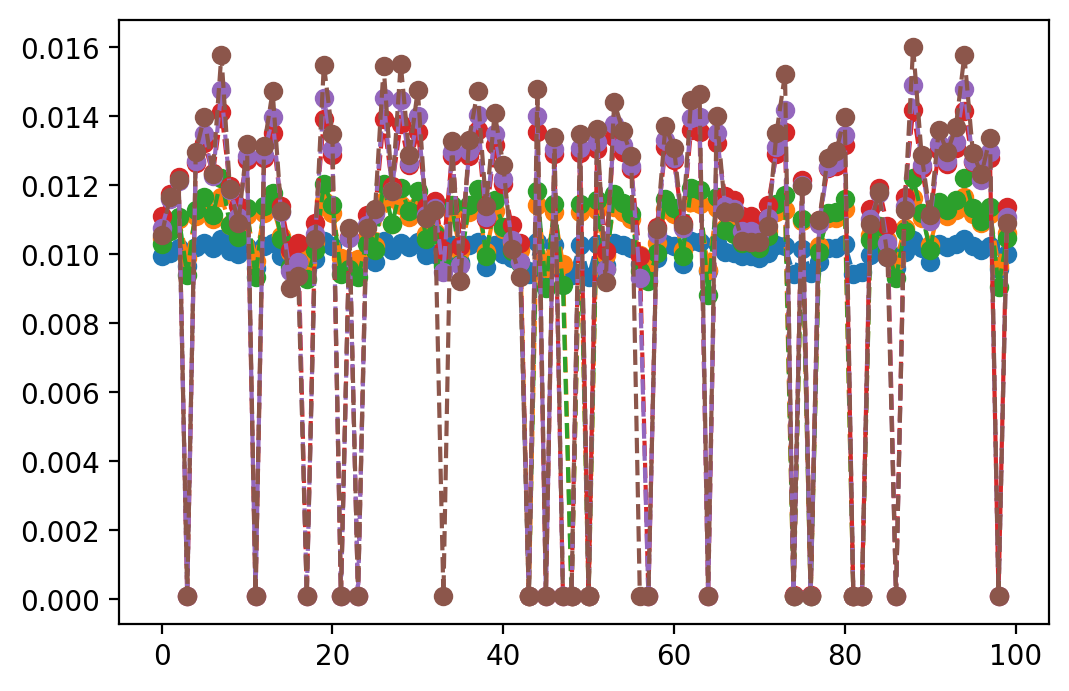

In [59]:
# train on r_genes only,
reload()
output_mat = dic_to_array(data1, [r_gene[0:100]])
# output_mat_norm_log_norm = dataset_gen.normalized_row(output_mat).T
# output_mat_norm_log_norm = output_mat.T
# print([index == True])
data_dim, cell_dim = output_mat.shape
max_epoch = 200
code_dim = 1
hidden_layers = [64]
# hidden_layers = [16, 8]
step_size = 0.1
num_iter = 5
train_len = int(cell_dim * 0.98)
print(cell_dim)
print(train_len)
init_weight = 1 * np.array([1/data_dim]*data_dim) + 0 * np.array(([1/len(l_zonated)]*len(l_zonated) + [0] * (data_dim - len(l_zonated))))
init_cell_weight = np.array([1/train_len]*train_len)

algo_output7 = sudo_algo2.multi_weight_weightedMSE(output_mat, data_dim, max_epoch, code_dim, hidden_layers, step_size, num_iter, init_weight,init_cell_weight, True)



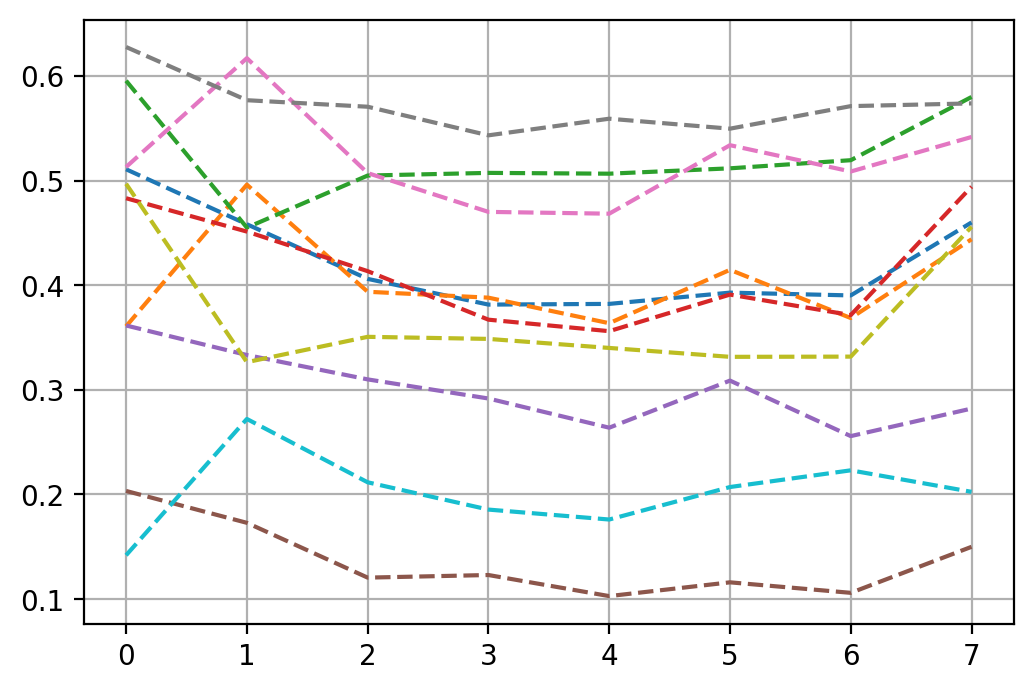

In [60]:
# attempt to find average value for each of the 8 layers for original data
output_mat = dic_to_array(data1, [r_gene[0:100]])
codes = get_encoder(algo_output7[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in z_gene[0:10]:
    res.append(partial_average(data1[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)
    

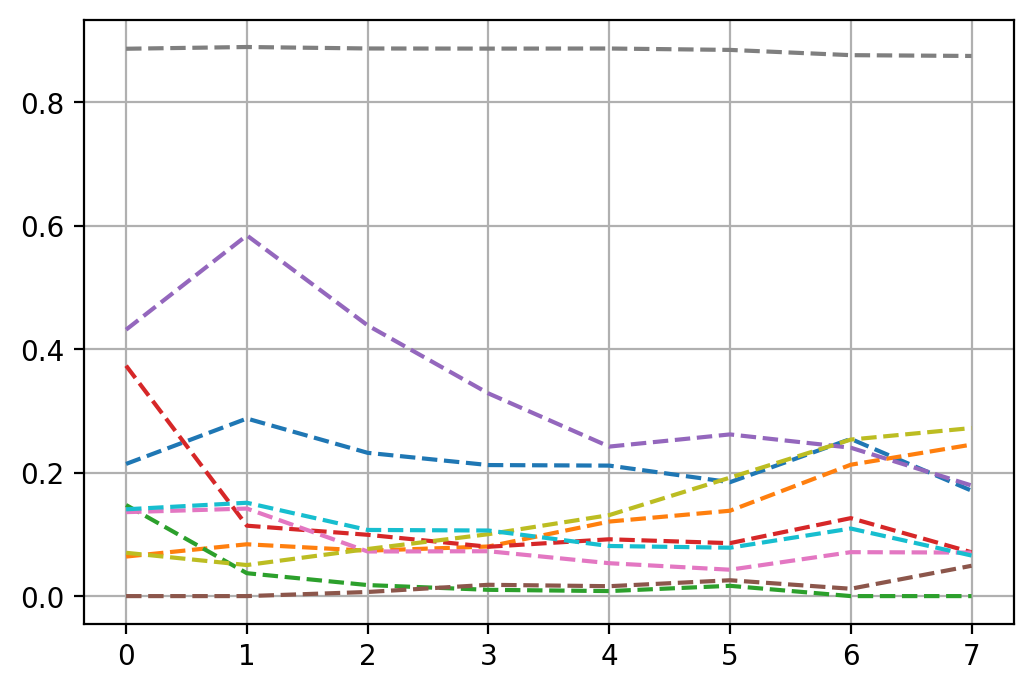

In [61]:
# attempt to find average value for each of the 8 layers for original data
output_mat = dic_to_array(data1, [r_gene[0:100]])
codes = get_encoder(algo_output7[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in r_gene[0:10]:
    res.append(partial_average(data1[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

1.1590501403804055e-06


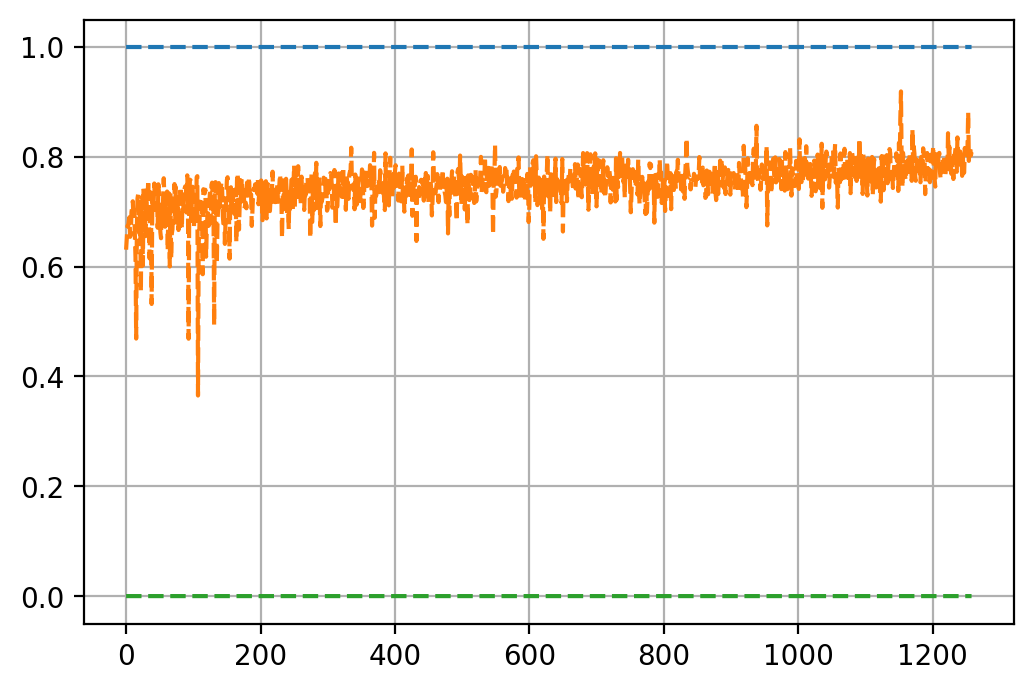

In [65]:
# find the smallest positive value
print(np.min([np.where(data_mat_norm_total[g] > 0, data_mat_norm_total[g], np.inf).min() for g in total_gene]))

# preprocessing
data_total = {}
for g in data_mat_norm_total.keys():
    temp = data_mat_norm_total[g] + np.array([1e-08] * len(data_mat_norm_total[g]))
    data_total[g] = np.log2(np.array(temp))
    data_total[g] = np.array(shift(data_total[g], g))
#     if np.all([np.array(data_total[g]) == 0]):
#         print(g)
#     else:
#         data_total[g] = dataset_gen.normalized_row_nan(np.array([data_total[g]]))[0]
# # check the min and max of each gene 
plot_vec([[np.max(data_total[g]) for g in z_gene], [np.where(data_total[g] > 0, data_total[g], np.inf).min() for g in z_gene], [np.min(data_total[g]) for g in z_gene]])

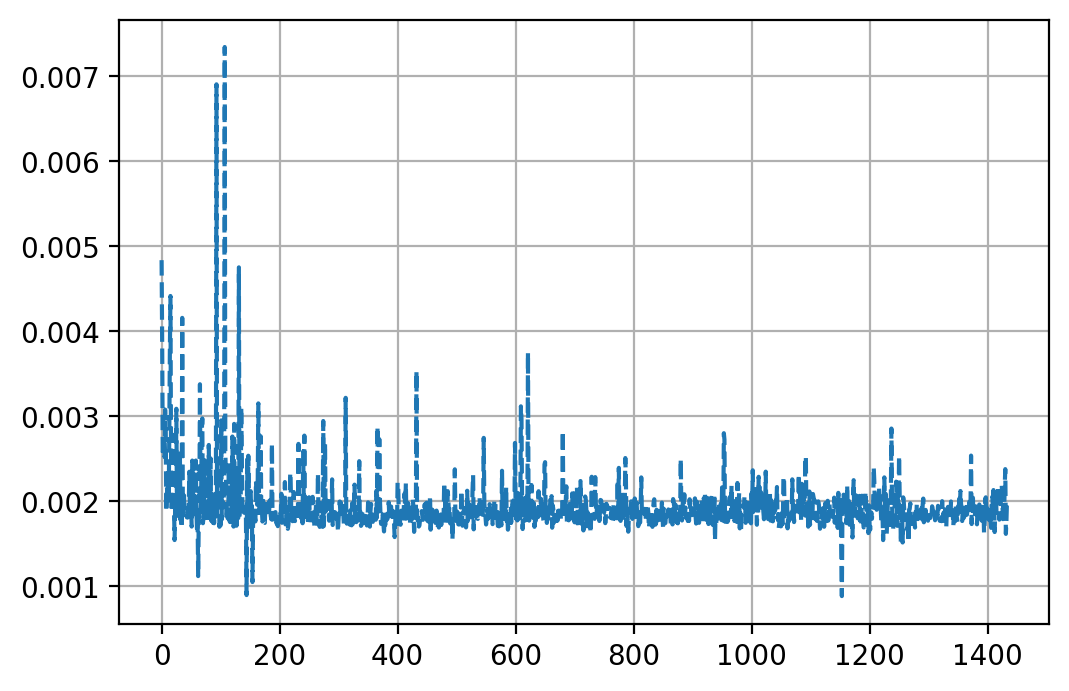

In [66]:
# check the variance of non zero cell expressions for each gene
plot_vec([[np.var(data_total[g][data_total[g] != 0]) for g in z_gene + r_gene]])

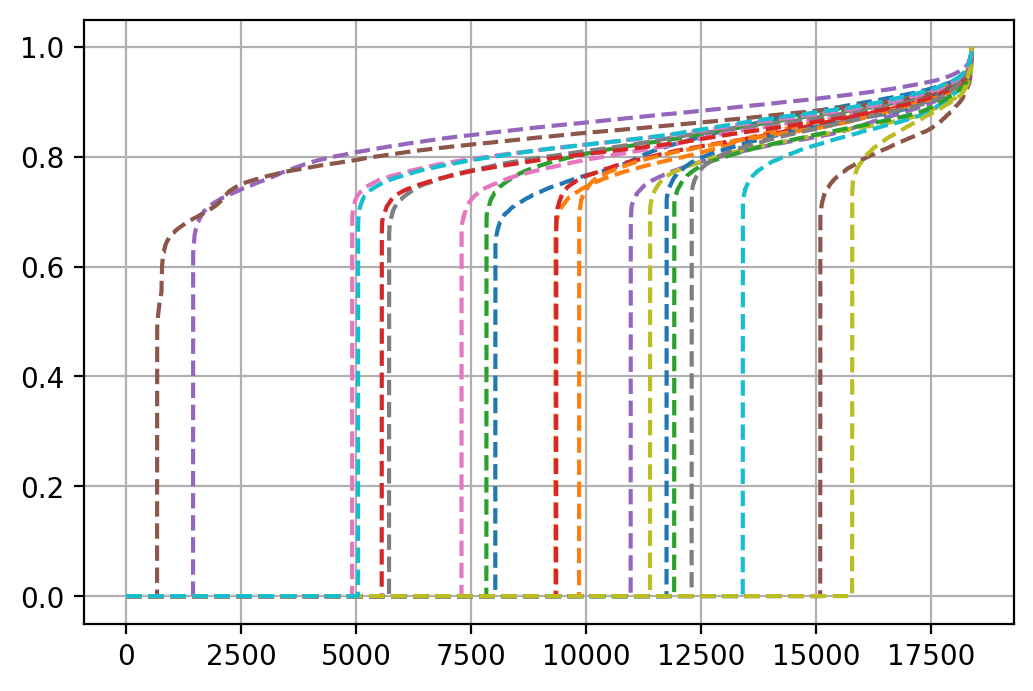

In [67]:
plot_vec([data_total[z_gene[i]][np.argsort(data_total[z_gene[i]])] for i in range(20)])

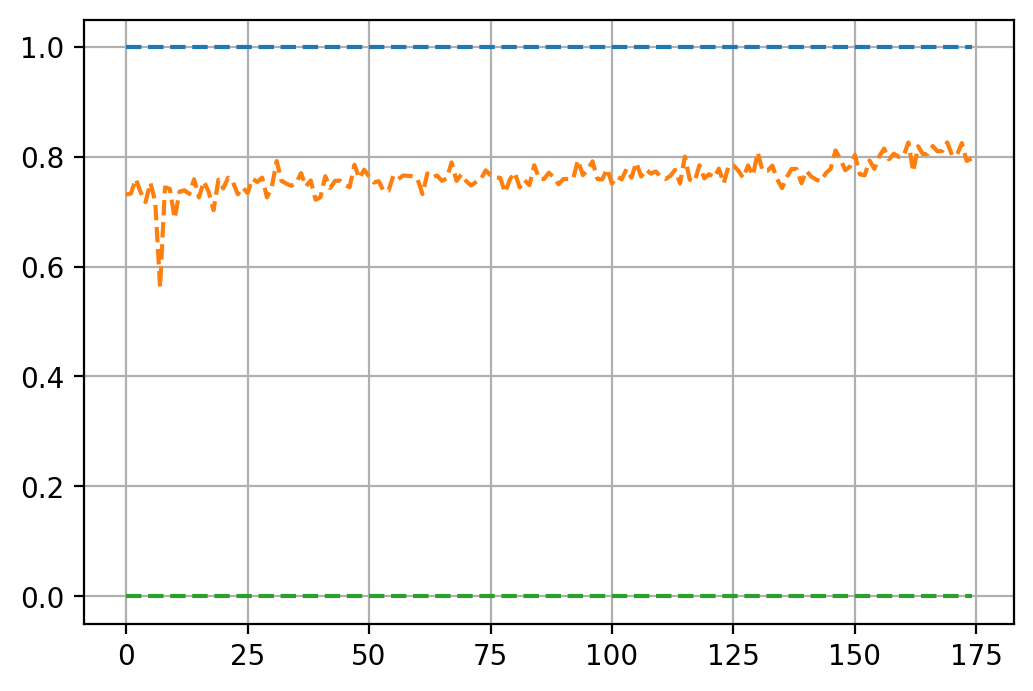

In [68]:
plot_vec([[np.max(data_total[g]) for g in r_gene], [np.where(data_total[g] > 0, data_total[g], np.inf).min() for g in r_gene], [np.min(data_total[g]) for g in r_gene]])


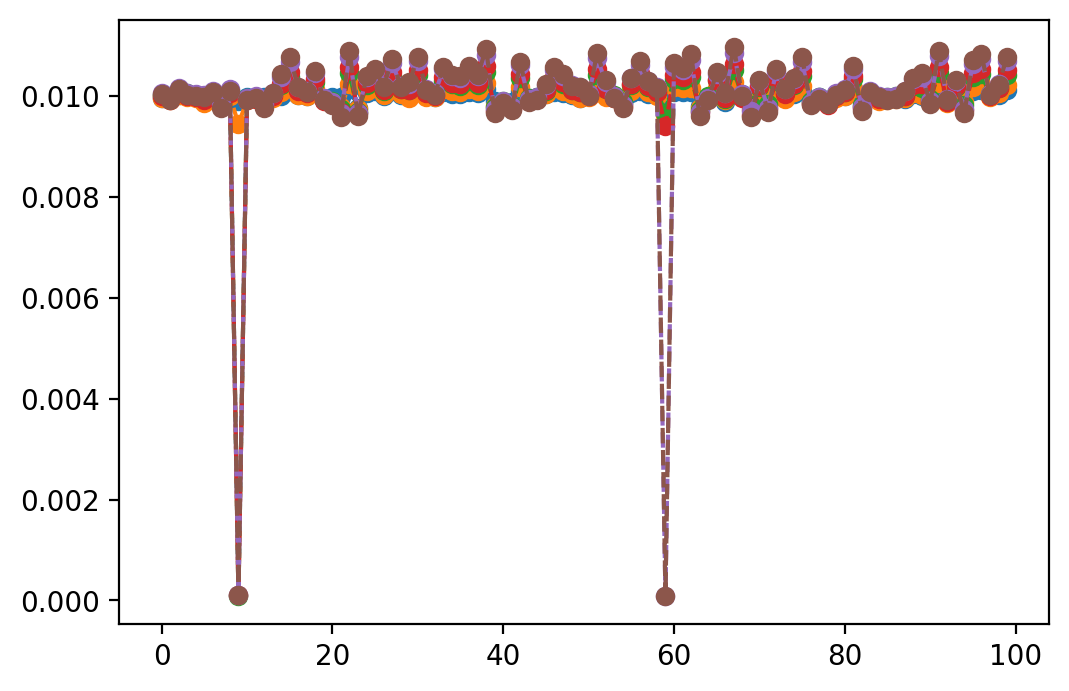

1.0


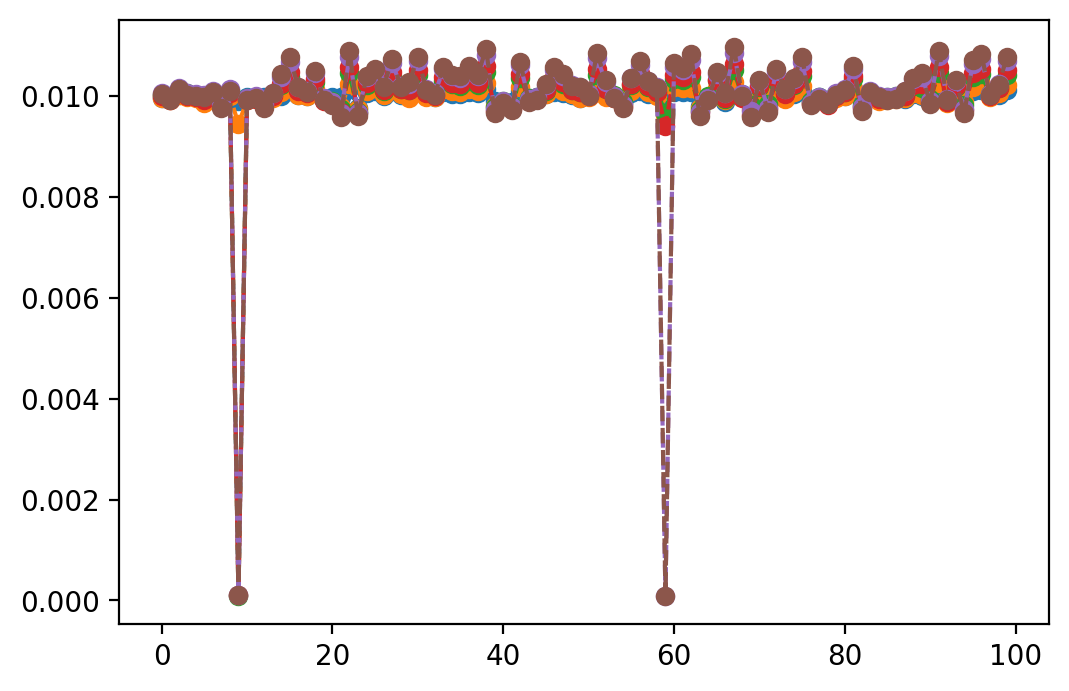

In [168]:
reload()
output_mat = dic_to_array(data_total, [z_gene[0:100]])
# output_mat_norm_log_norm = dataset_gen.normalized_row(output_mat).T
# output_mat_norm_log_norm = output_mat.T
# print([index == True])
data_dim, cell_dim = output_mat.shape
max_epoch = 200
code_dim = 1
hidden_layers = [128]
# hidden_layers = [16, 8]
step_size = 0.1
num_iter = 5
train_len = int(cell_dim * 0.98)
print(cell_dim)
print(train_len)
init_weight = 1 * np.array([1/data_dim]*data_dim) + 0 * np.array(([1/len(l_zonated)]*len(l_zonated) + [0] * (data_dim - len(l_zonated))))
# init_weight = np.sum([output_mat >0][0], axis = 1)/ np.sum(np.sum([output_mat >0][0]))


init_cell_weight = np.array([1/train_len]*train_len)

algo_output10 = sudo_algo2.multi_weight_weightedMSE(output_mat, data_dim, max_epoch, code_dim, hidden_layers, step_size, num_iter, init_weight,init_cell_weight, True)



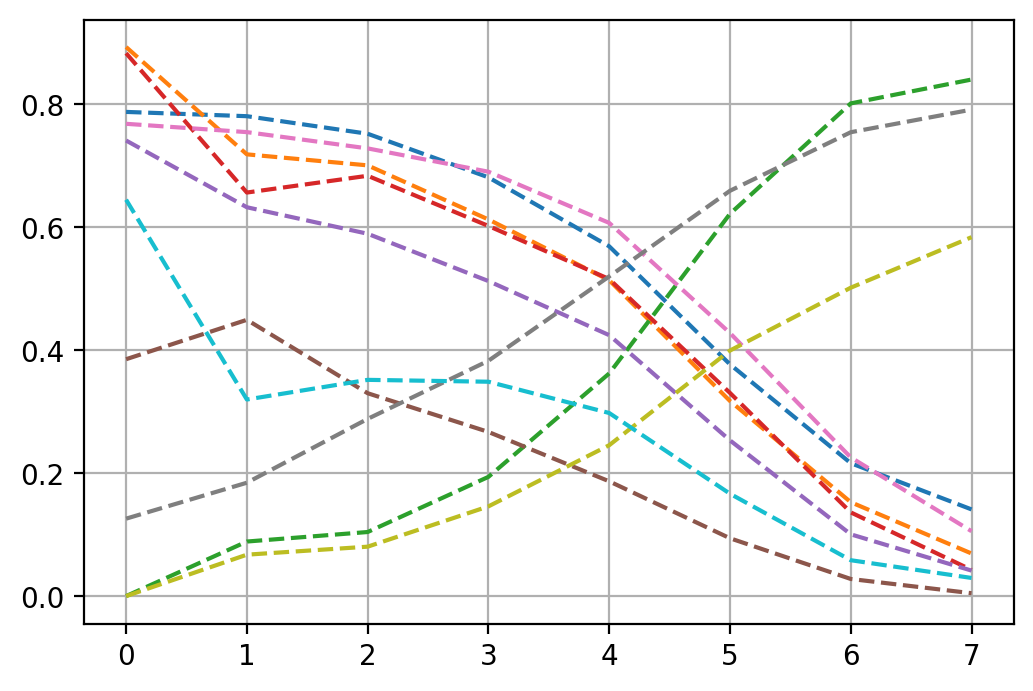

In [170]:
# attempt to find average value for each of the 8 layers
# output_mat = dic_to_array(data_total, [z_gene])
codes = get_encoder(algo_output10[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in z_gene[0:10]:
    res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

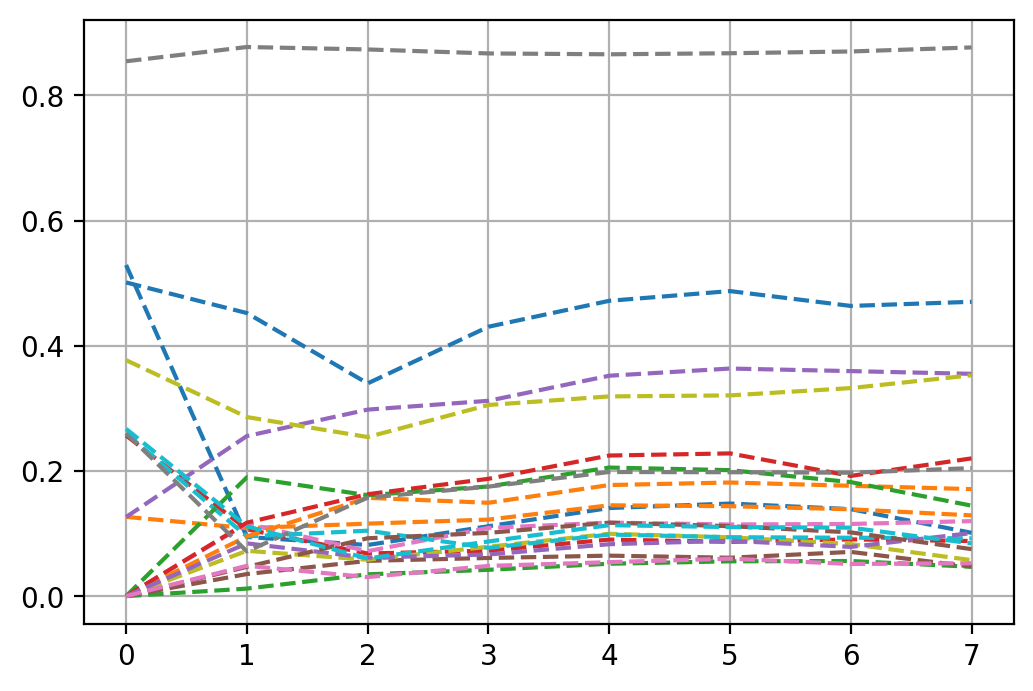

In [171]:
# attempt to find average value for each of the 8 layers
# output_mat = dic_to_array(data_total, [z_gene[0:400]])
codes = get_encoder(algo_output10[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in r_gene[0:20]:
    res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

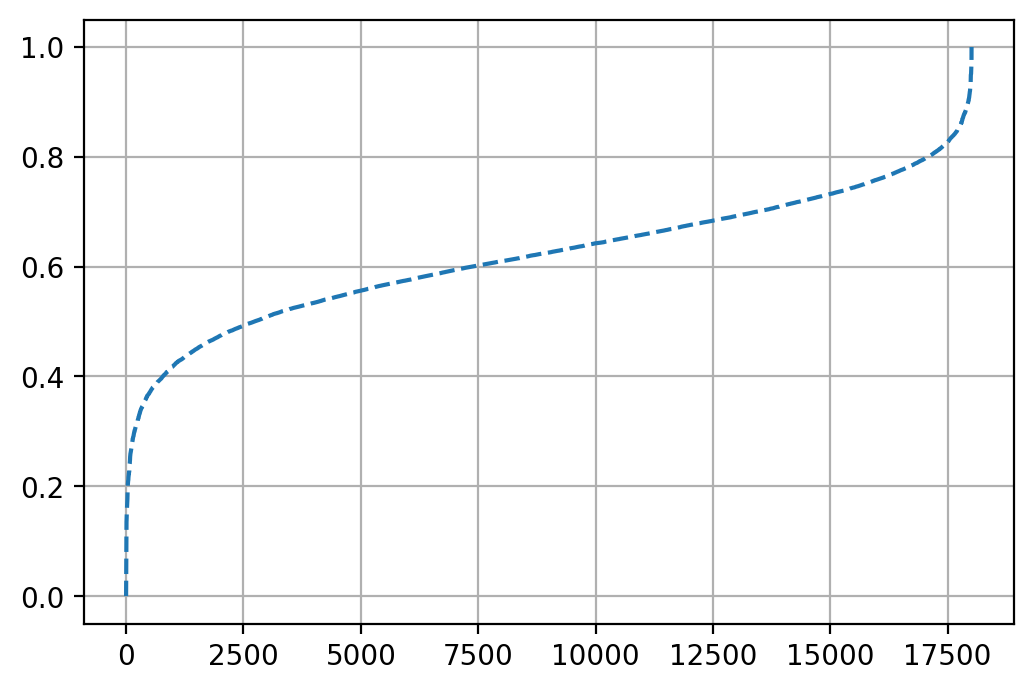

In [172]:
codes = get_encoder(algo_output10[0], output_mat[:, 0:train_len])

shifted_codes = shift(codes, 'none')
plot_vec([np.sort(np.array(shifted_codes).T)[0]])

(18010, 100)


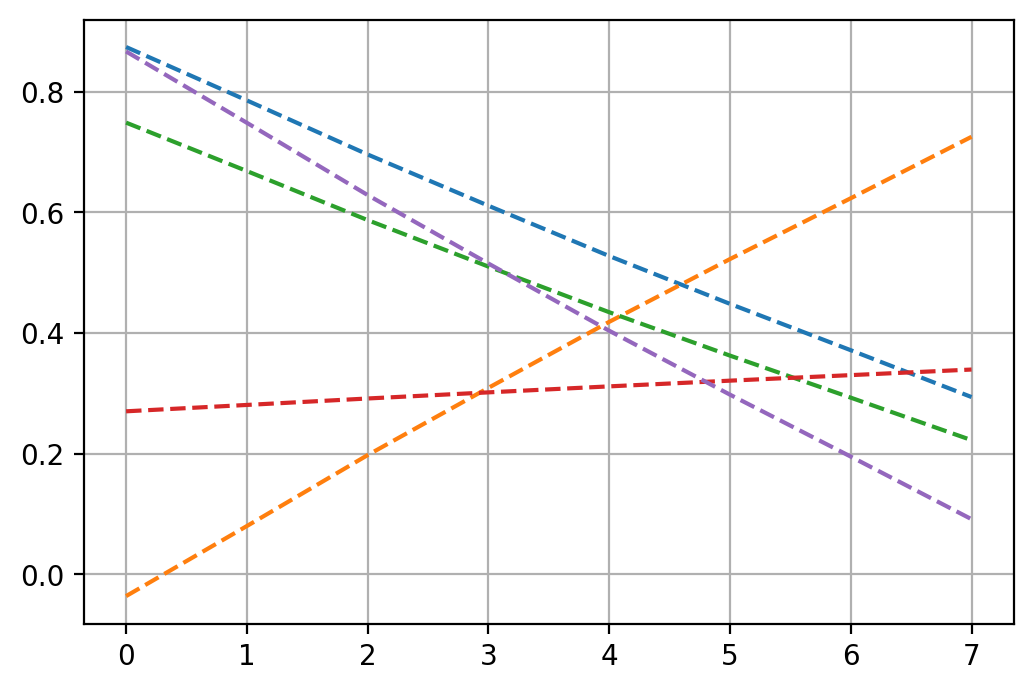

In [173]:
# plot average of reconstruction for some genes based on encoding of cells
# [np.where(data1[g][0] > -22, data1[g][0], np.inf).min() for g in z_gene]
# output_mat = dic_to_array(data_total, [z_gene[0:100]])
outputs = np.array(get_output(algo_output10[0], output_mat[:, 0:train_len]))
print(outputs.shape)
res = []
for i in [1, 2, 5, 10, 50]:
#     res.append(data1[z_gene[i]])
    res.append(partial_average(outputs[:, i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

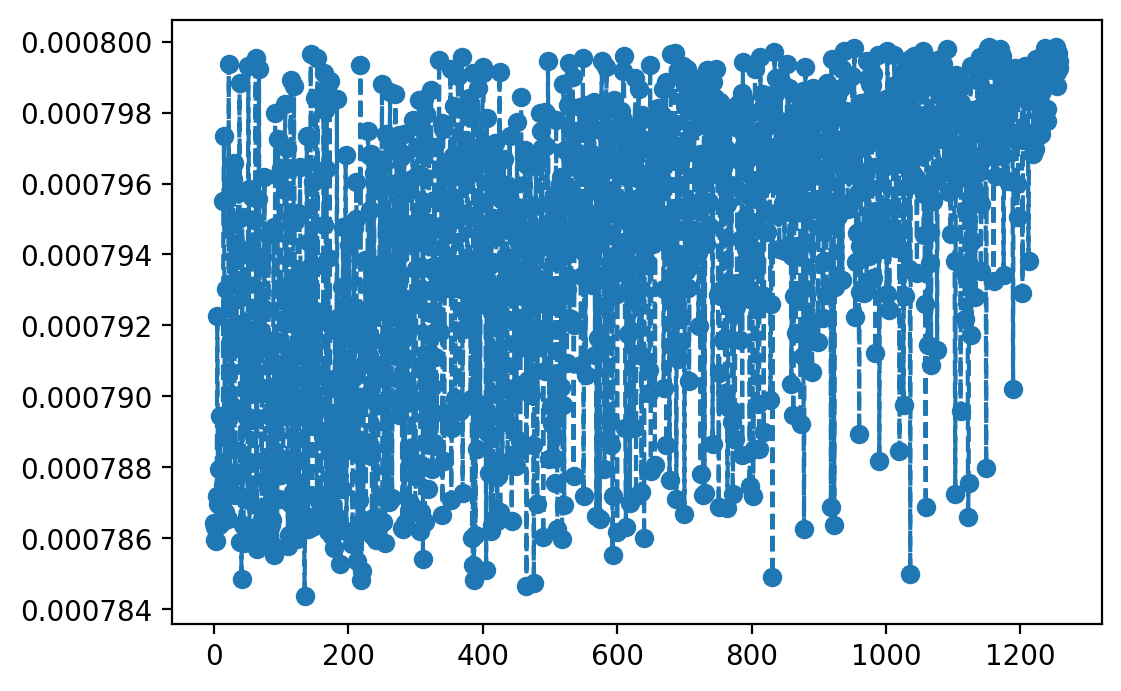

1e+00


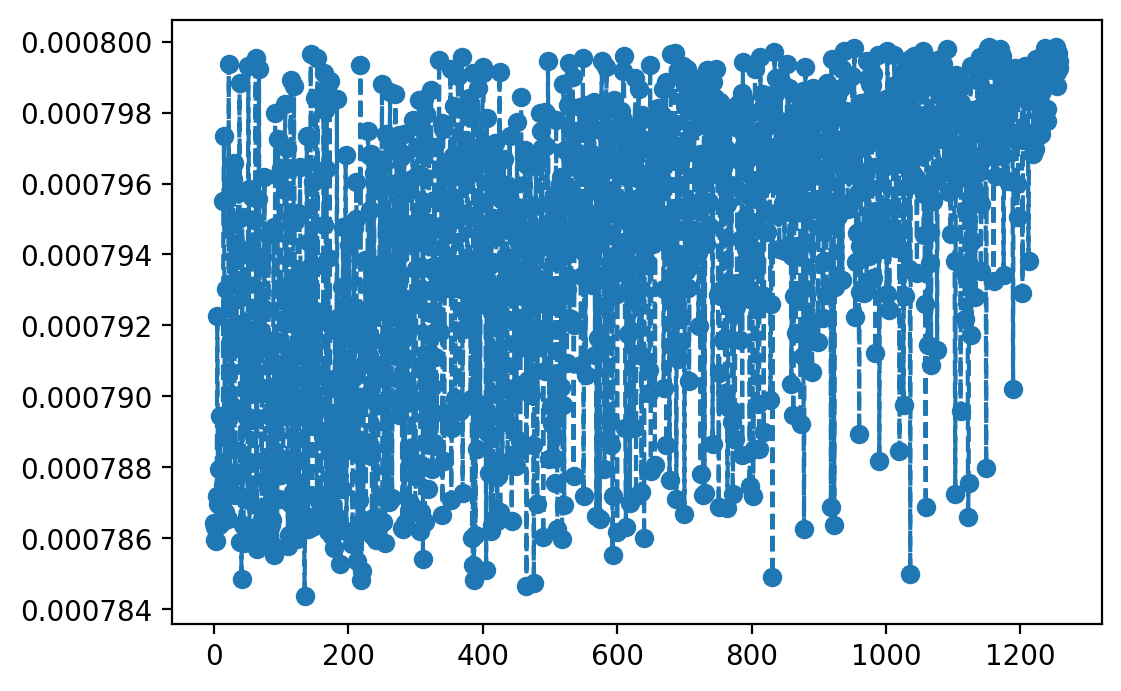

In [41]:
reload()
output_mat = dic_to_array(data_total, [z_gene])
# output_mat_norm_log_norm = dataset_gen.normalized_row(output_mat).T
# output_mat_norm_log_norm = output_mat.T
# print([index == True])
data_dim, cell_dim = output_mat.shape
max_epoch = 500
code_dim = 1
# hidden_layers = [64, 8]
hidden_layers = [128]
step_size = 0.1
num_iter = 0
train_len = int(cell_dim * 0.98)
print(cell_dim)
print(train_len)
init_weight = 1 * np.array([1/data_dim]*data_dim) + 0 * np.array(([1/len(l_zonated)]*len(l_zonated) + [0] * (data_dim - len(l_zonated))))
init_cell_weight = np.array([1/train_len]*train_len)

algo_output11 = sudo_algo2.multi_weight_weightedMSE(output_mat, data_dim, max_epoch, code_dim, hidden_layers, step_size, num_iter, init_weight,init_cell_weight, False)



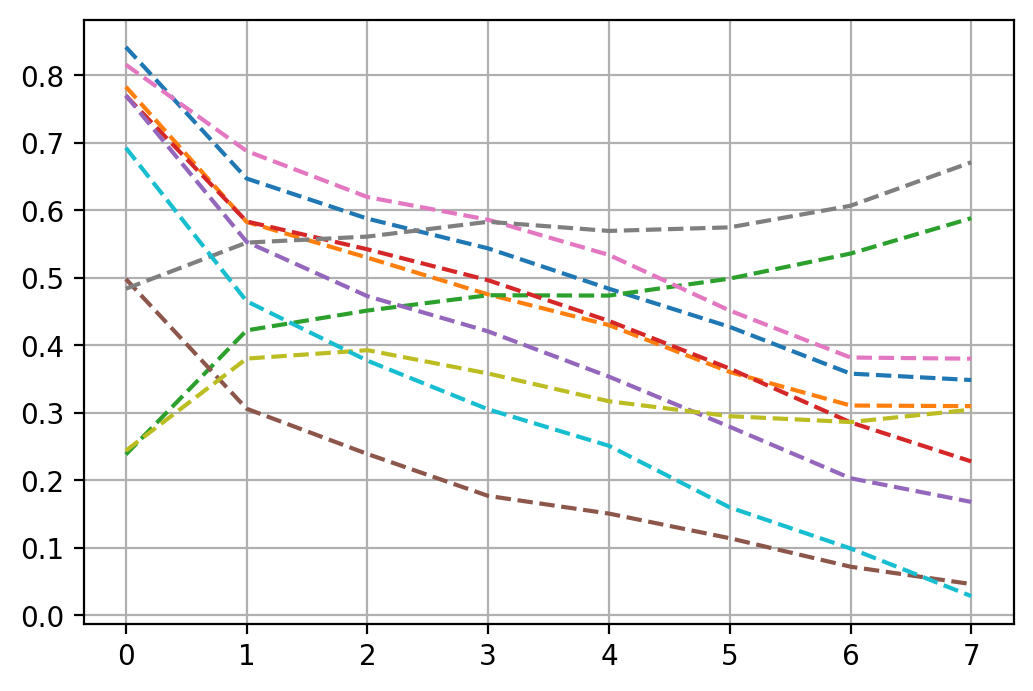

In [44]:
# attempt to find average value for each of the 8 layers 
output_mat = dic_to_array(data_total, [z_gene])
codes = get_encoder(algo_output11[0], output_mat[:, 0:train_len])
# print(codes)
shifted_codes = shift(codes, 'none')
res = []
for i in z_gene[0:10]:
    res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

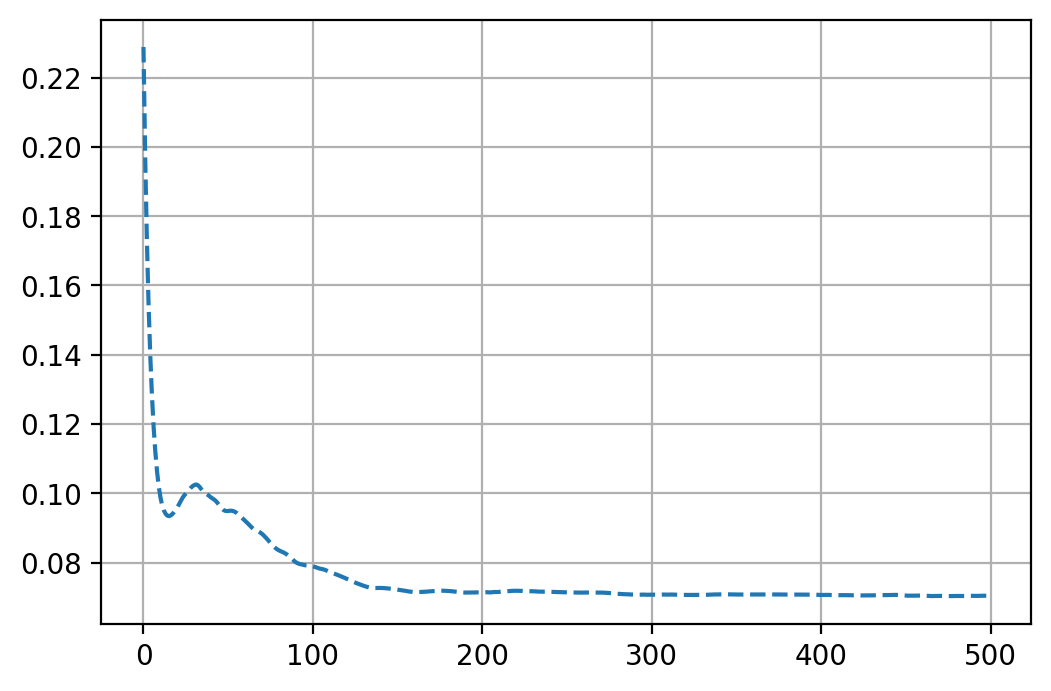

In [45]:
# plot reconstruction error
plot_vec([algo_output11[-1][0]])

In [46]:
reload()
# cur_list = [list(total_gene)[i] for i in partition[0]]
output_mat = dic_to_array(data_total, [r_gene])
# output_mat_norm_log_norm = dataset_gen.normalized_row(output_mat).T
# output_mat_norm_log_norm = output_mat.T
# print([index == True])
data_dim, cell_dim = output_mat.shape
max_epoch = 1000
code_dim = 1
# hidden_layers = [64, 8]
hidden_layers = [16, 8]
step_size = 0.1
num_iter = 0
train_len = int(cell_dim * 0.98)
print(cell_dim)
print(train_len)
init_weight = 1 * np.array([1/data_dim]*data_dim) + 0 * np.array(([1/len(l_zonated)]*len(l_zonated) + [0] * (data_dim - len(l_zonated))))
init_cell_weight = np.array([1/train_len]*train_len)

algo_output13 = sudo_algo2.multi_weight_weightedMSE(output_mat, data_dim, max_epoch, code_dim, hidden_layers, step_size, num_iter, init_weight,init_cell_weight, False)


18378
18010
training with data-dim: 175max epoch: 1000code-dim: 1dimension of hidden layers are: [16, 8]step-size: 0.1
num sample is 10
cur iteration is 0
18010
{'input_shape': 175, 'code_dim': 1, 'list_dim': [16, 8]}
max_loss isinf
[1/1000] Loss: 0.1043563326219003
[2/1000] Loss: 0.10178285807746634
[3/1000] Loss: 0.09946503994888352
[4/1000] Loss: 0.09737761417928376
[5/1000] Loss: 0.09547726131901439
[6/1000] Loss: 0.09373218966346385
[7/1000] Loss: 0.09211330185915731
[8/1000] Loss: 0.09060538397878902
[9/1000] Loss: 0.08919155992101034
[10/1000] Loss: 0.08785885935385448
[11/1000] Loss: 0.08659752209041917
[12/1000] Loss: 0.08540037040016821
[13/1000] Loss: 0.08426174439716959
[14/1000] Loss: 0.08317745337544258
[15/1000] Loss: 0.08214354672269629
[16/1000] Loss: 0.08115549051108685
[17/1000] Loss: 0.08021262082541297
[18/1000] Loss: 0.07930964424752084


KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

(18010,)


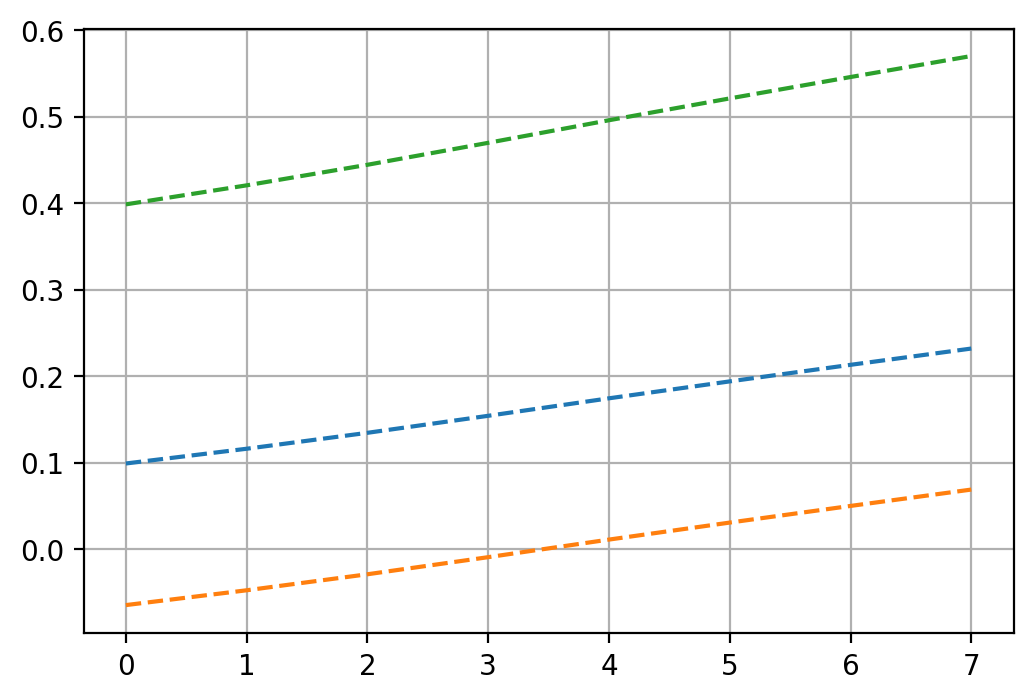

In [240]:
# plot average of reconstruction for some genes based on encoding of cells
# [np.where(data1[g][0] > -22, data1[g][0], np.inf).min() for g in z_gene]
output_mat = dic_to_array(data_total, [r_gene])
outputs = np.array(get_output(algo_output13[0], output_mat[:, 0:train_len]))
print(outputs[:, 0].shape)
res = []
for i in [0, 5, 10]:
#     res.append(data_total[r_gene[i]])
    res.append(partial_average(outputs[:, i][0:train_len], np.array(shifted_codes).T[0]))
#     res.append(outputs[:, i][0:train_len])
plot_vec(res)

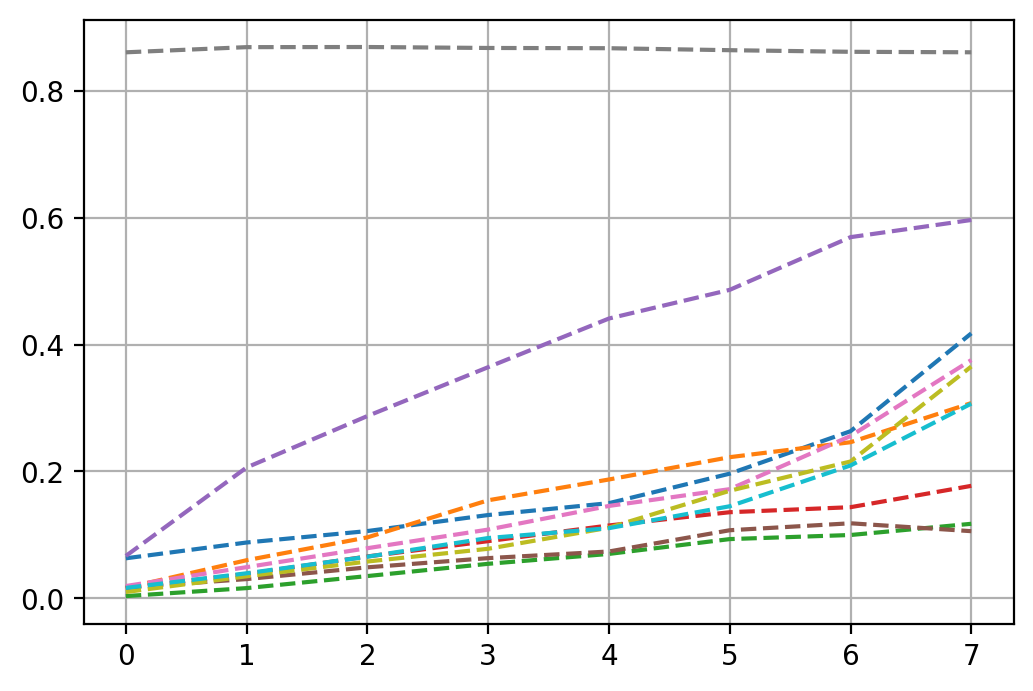

In [226]:
codes = get_encoder(algo_output13[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in r_gene[0:10]:
    if i in r_gene:
        res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

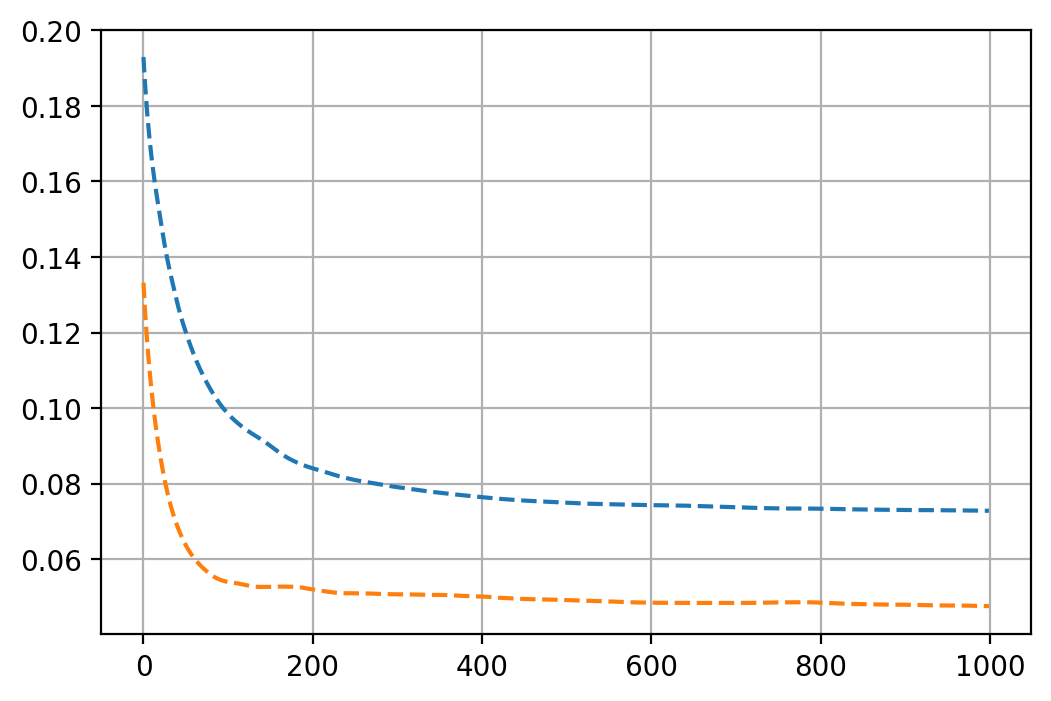

In [243]:
plot_vec([algo_output11[-1][0], algo_output13[-1][0]])

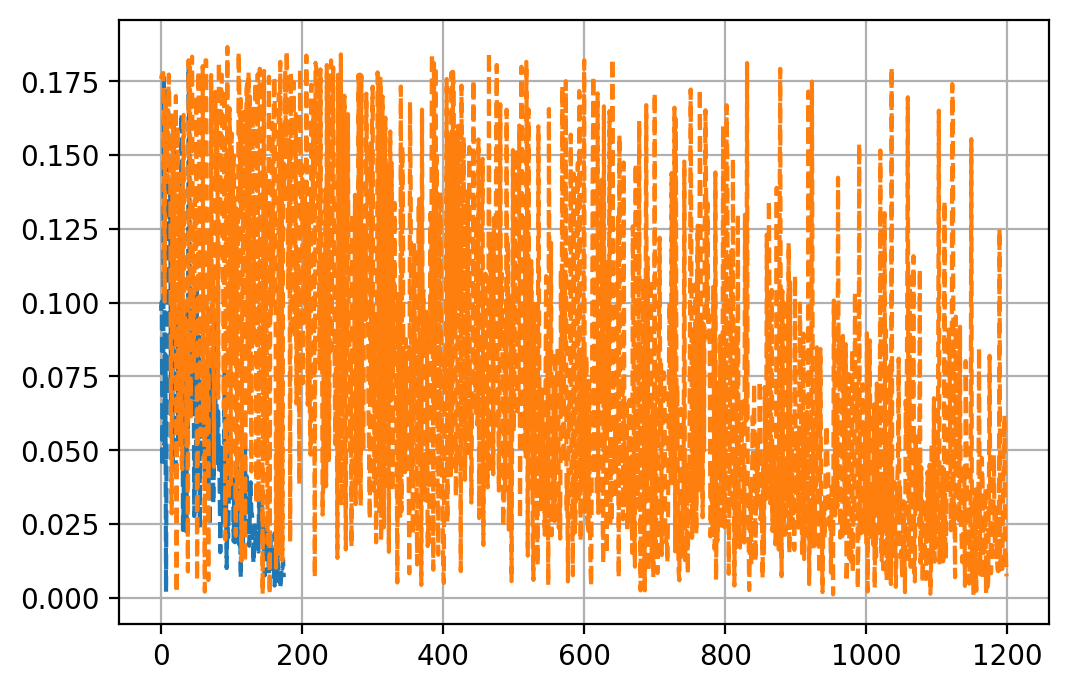

In [241]:
plot_vec([[np.var(data_total[r_gene[i]]) for i in range(175)], [np.var(data_total[z_gene[i]]) for i in range(1200)]])

2
4
6


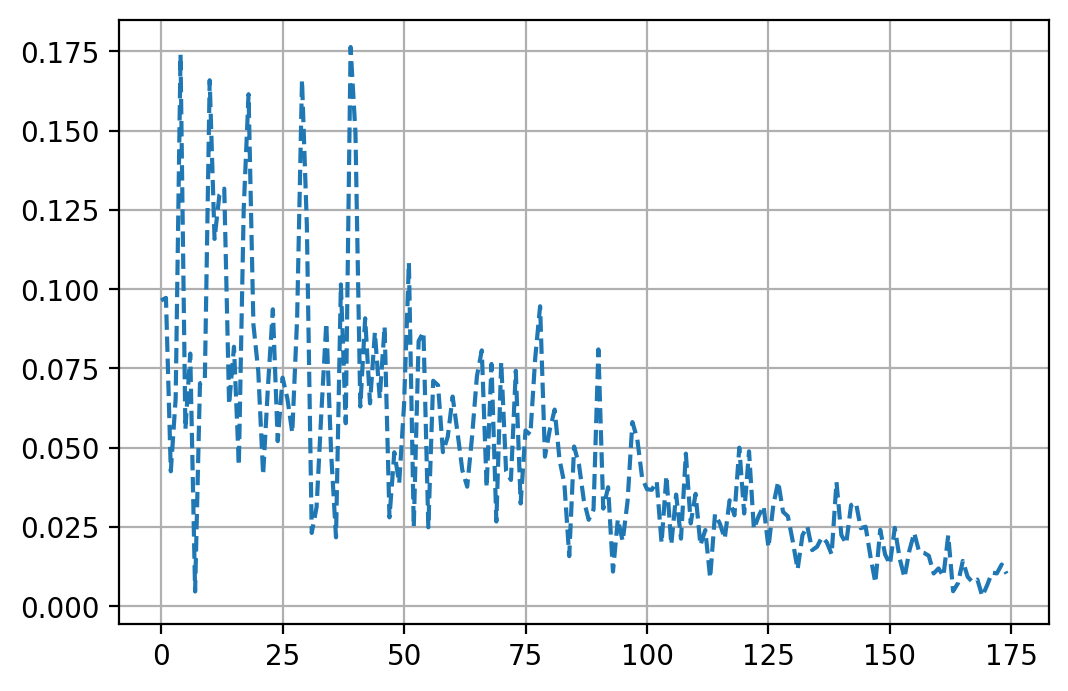

In [229]:
result11 = find_last_reconstruction_error(algo_output13[0], output_mat[:, 0:train_len], [1]*len(init_weight), init_cell_weight)
for i in range(len(l_circadian)):
    if l_circadian[i] in r_gene:
        print(i)
plot_vec([result11])


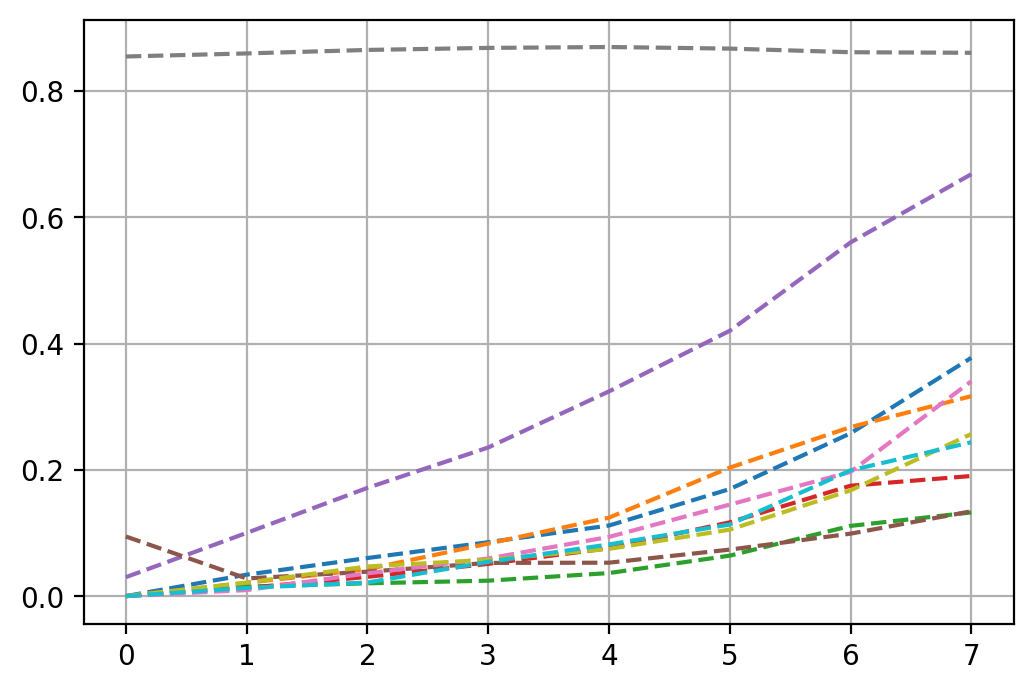

In [154]:
# attempt to find average value for each of the 8 layers 
output_mat = dic_to_array(data_total, [r_gene])
codes = get_encoder(algo_output12[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in r_gene[0:10]:
    if i in r_gene:
        res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

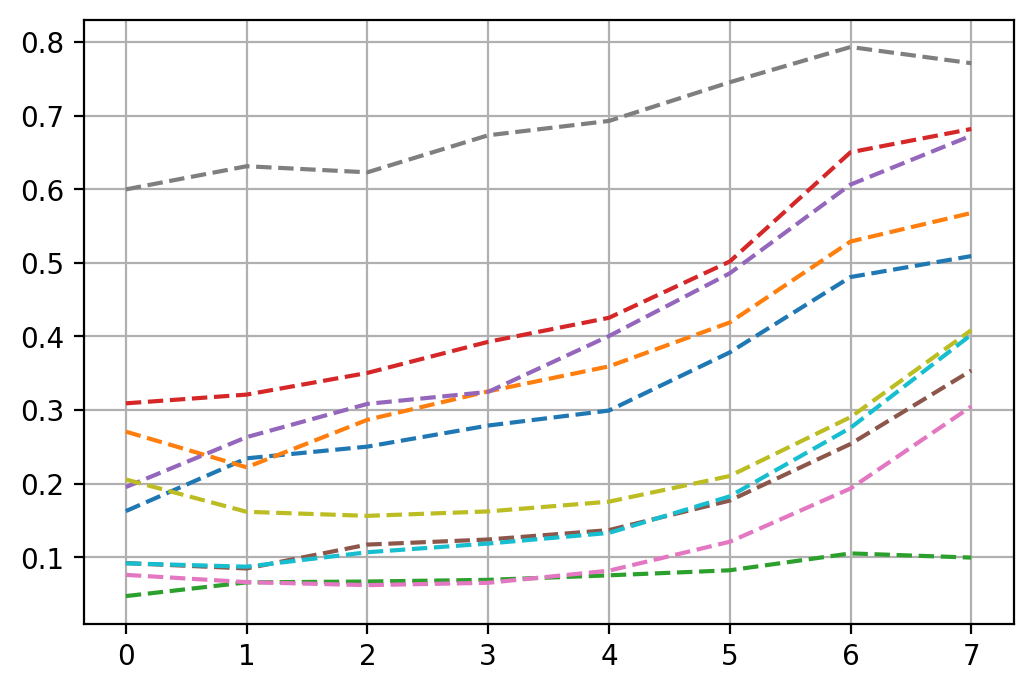

In [155]:
res = []
for i in z_gene[40:50]:
    res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

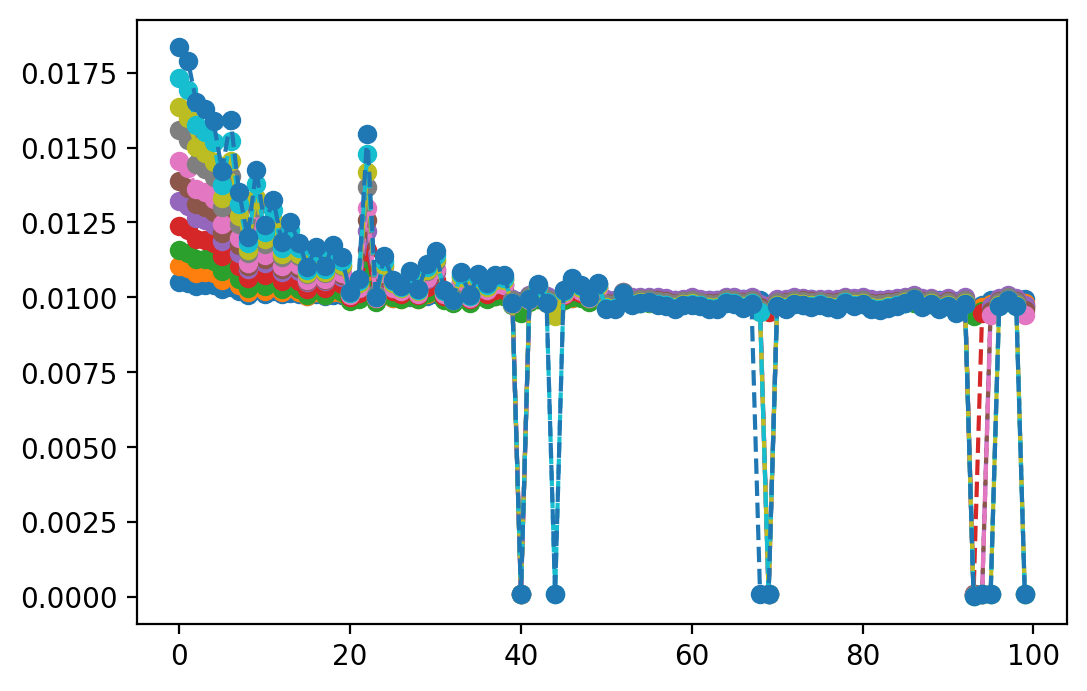

0.9999999999999999


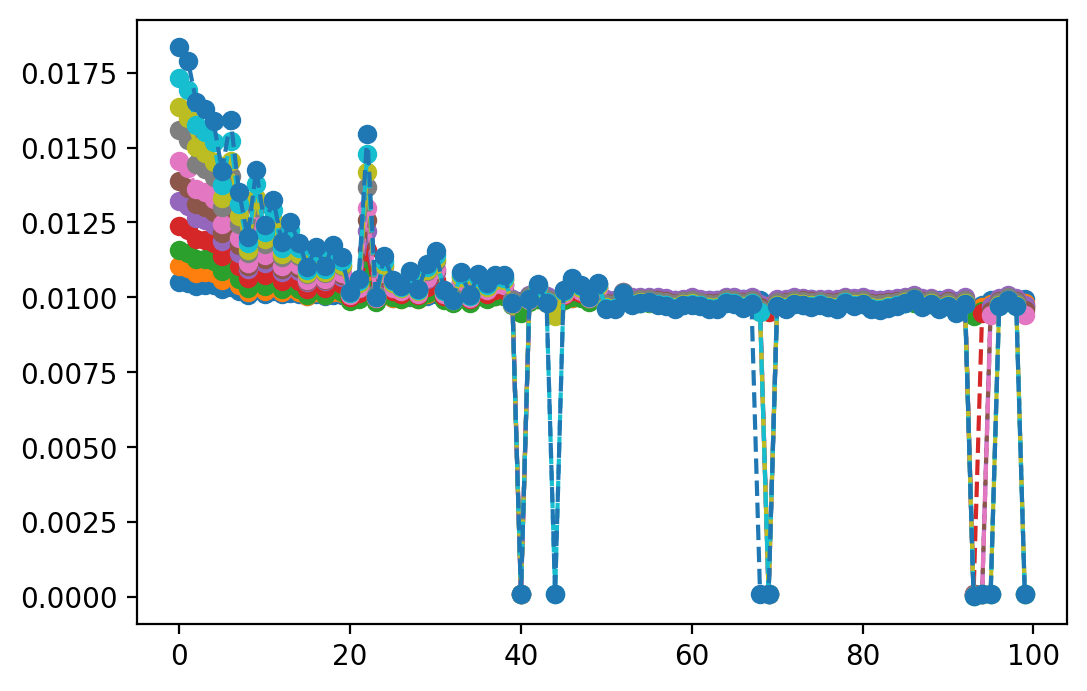

In [174]:
reload()
# cur_list = [list(total_gene)[i] for i in partition[0]]
output_mat = dic_to_array(data_total, [z_gene[0:50], r_gene[0:50]])
output_mat = dataset_gen.normalized_row(output_mat)
# output_mat_norm_log_norm = output_mat.T
# print([index == True])
data_dim, cell_dim = output_mat.shape
max_epoch = 200
code_dim = 1
# hidden_layers = [32, 16]
hidden_layers = [128]
step_size = 0.1
num_iter = 10
train_len = int(cell_dim * 0.98)
print(cell_dim)
print(train_len)
init_weight = 1 * np.array([1/data_dim]*data_dim) + 0 * np.array(([1/len(l_zonated)]*len(l_zonated) + [0] * (data_dim - len(l_zonated))))
init_cell_weight = np.array([1/train_len]*train_len)

algo_output12 = sudo_algo2.multi_weight_weightedMSE(output_mat, data_dim, max_epoch, code_dim, hidden_layers, step_size, num_iter, init_weight,init_cell_weight, True)




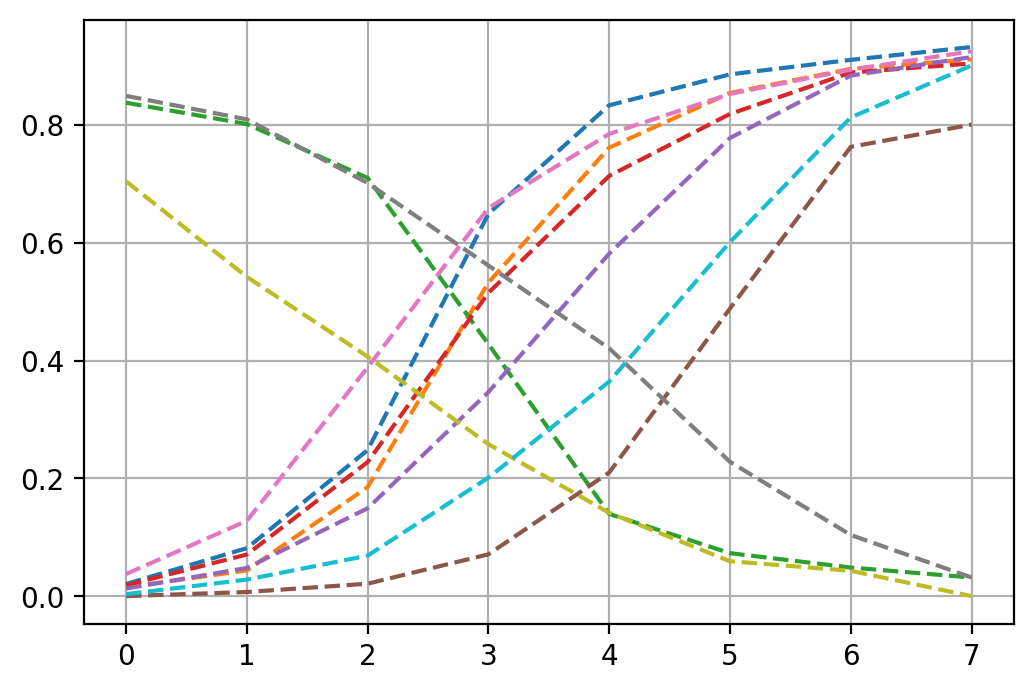

In [175]:
codes = get_encoder(algo_output12[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in z_gene[0:10]:
    if i in z_gene:
        res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

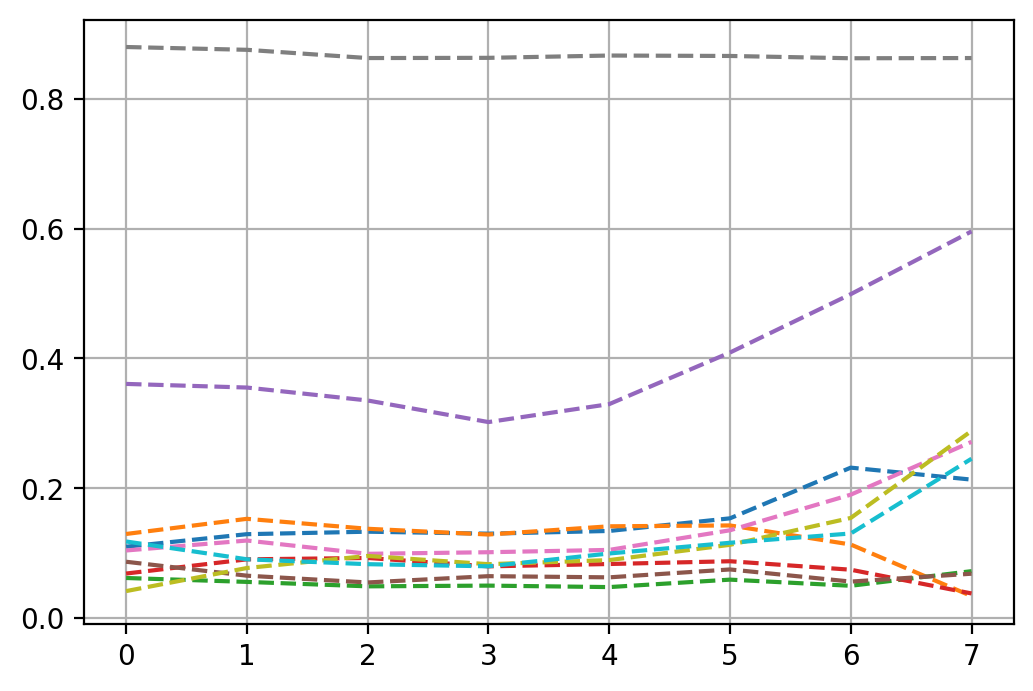

In [176]:
codes = get_encoder(algo_output12[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in r_gene[0:10]:
    if i in r_gene:
        res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

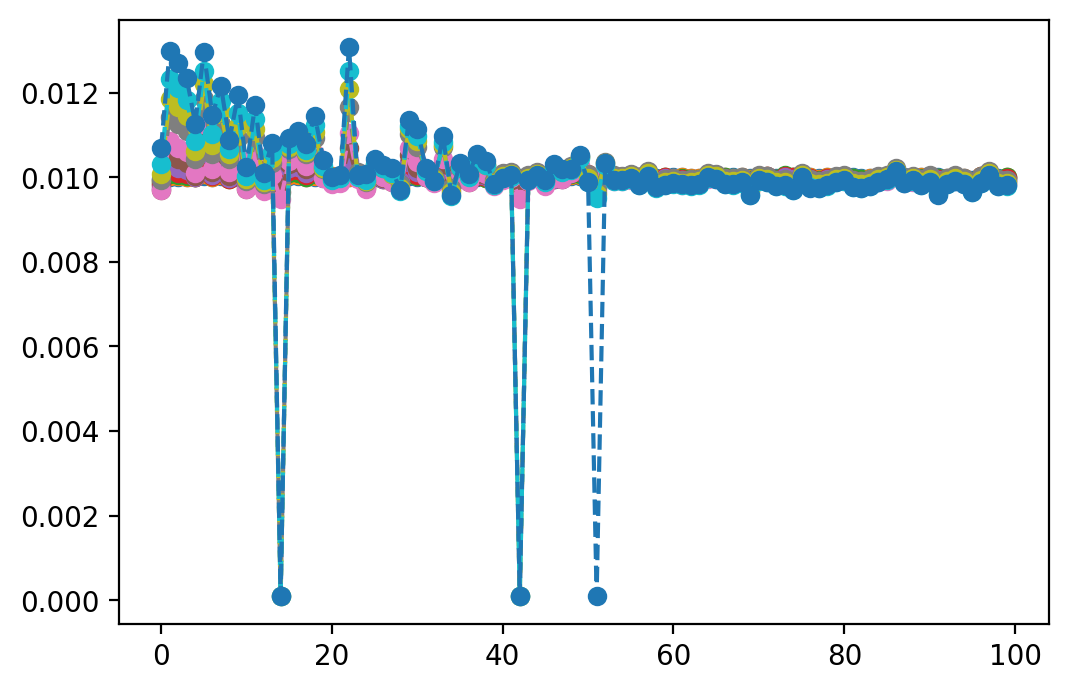

1.0000000000000002e+00


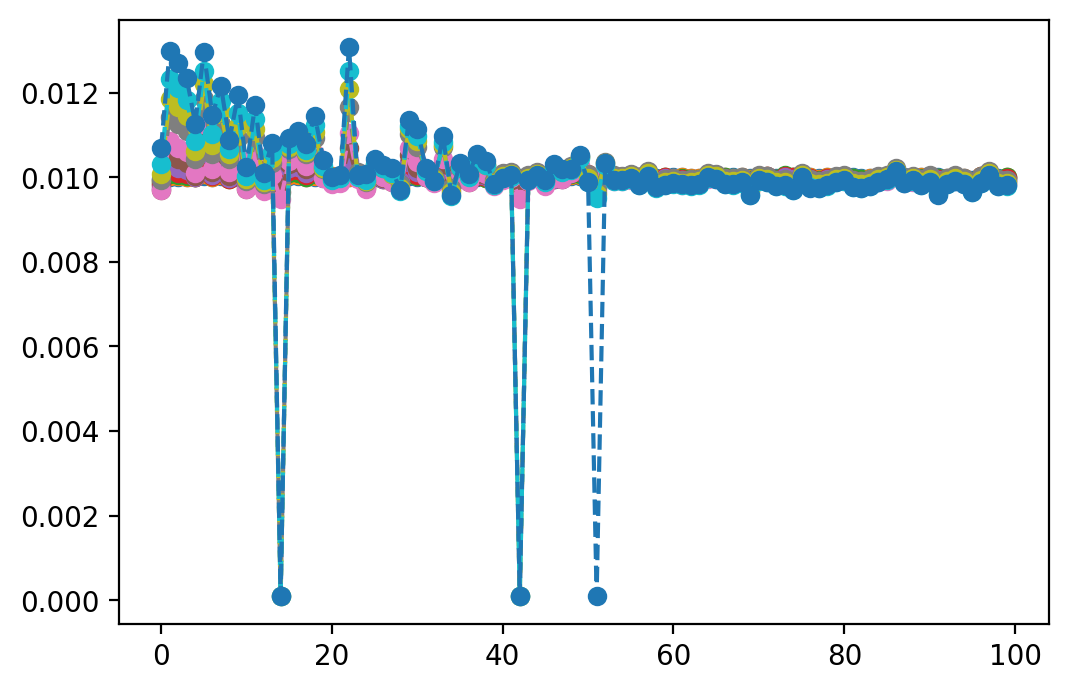

In [191]:
# 2 layer autoencoder
reload()

output_mat = dic_to_array(data_total, [z_gene[0:50], r_gene[0:50]])
output_mat = dataset_gen.normalized_row(output_mat)
# output_mat_norm_log_norm = output_mat.T
# print([index == True])
data_dim, cell_dim = output_mat.shape
max_epoch = 200
code_dim = 1
# hidden_layers = [32, 16]
hidden_layers = [16, 8]
step_size = 0.1
num_iter = 10
train_len = int(cell_dim * 0.98)
print(cell_dim)
print(train_len)
init_weight = 1 * np.array([1/data_dim]*data_dim) + 0 * np.array(([1/len(l_zonated)]*len(l_zonated) + [0] * (data_dim - len(l_zonated))))
init_cell_weight = np.array([1/train_len]*train_len)

algo_output12 = sudo_algo2.multi_weight_weightedMSE(output_mat, data_dim, max_epoch, code_dim, hidden_layers, step_size, num_iter, init_weight,init_cell_weight, True)



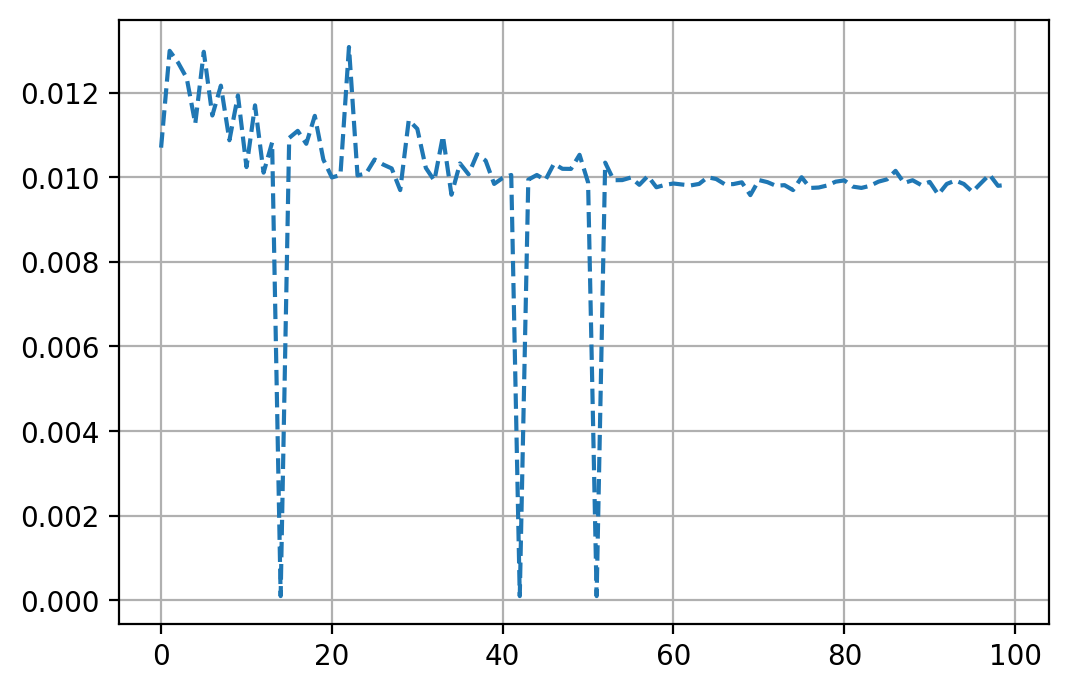

In [200]:
plot_vec([algo_output12[1]])

(18010,)


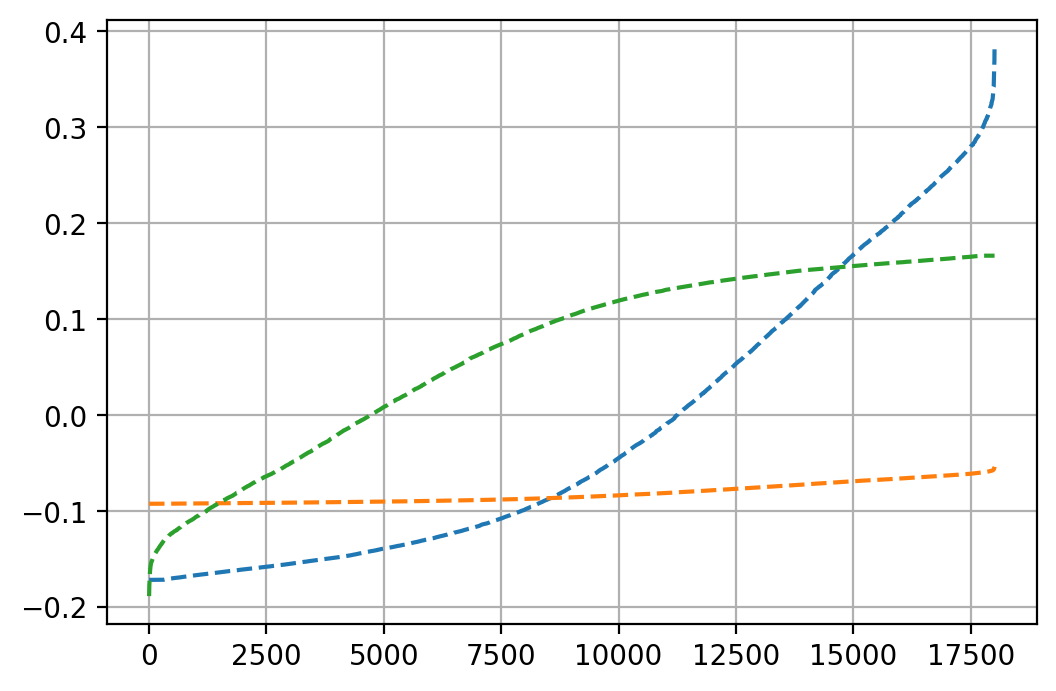

In [201]:
# plot average of reconstruction for some genes based on encoding of cells
# [np.where(data1[g][0] > -22, data1[g][0], np.inf).min() for g in z_gene]
outputs = np.array(get_output(algo_output12[0], output_mat[:, 0:train_len]))
print(outputs[:, 0].shape)
res = []
for i in [51, 52, 53]:
#     res.append(data1[z_gene[i]])
#     res.append(partial_average(outputs[:, i][0:train_len], np.array(shifted_codes).T[0]))
    res.append(np.sort(outputs[:, i][0:train_len]))
plot_vec(res)

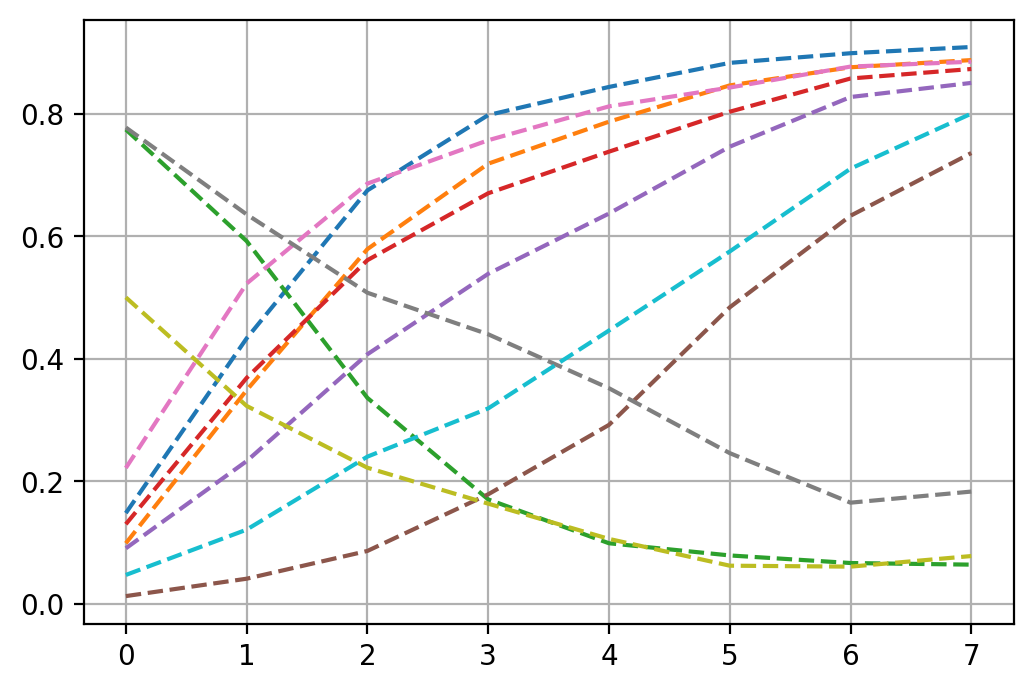

In [193]:
codes = get_encoder(algo_output12[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in z_gene[0:10]:
    if i in z_gene:
        res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

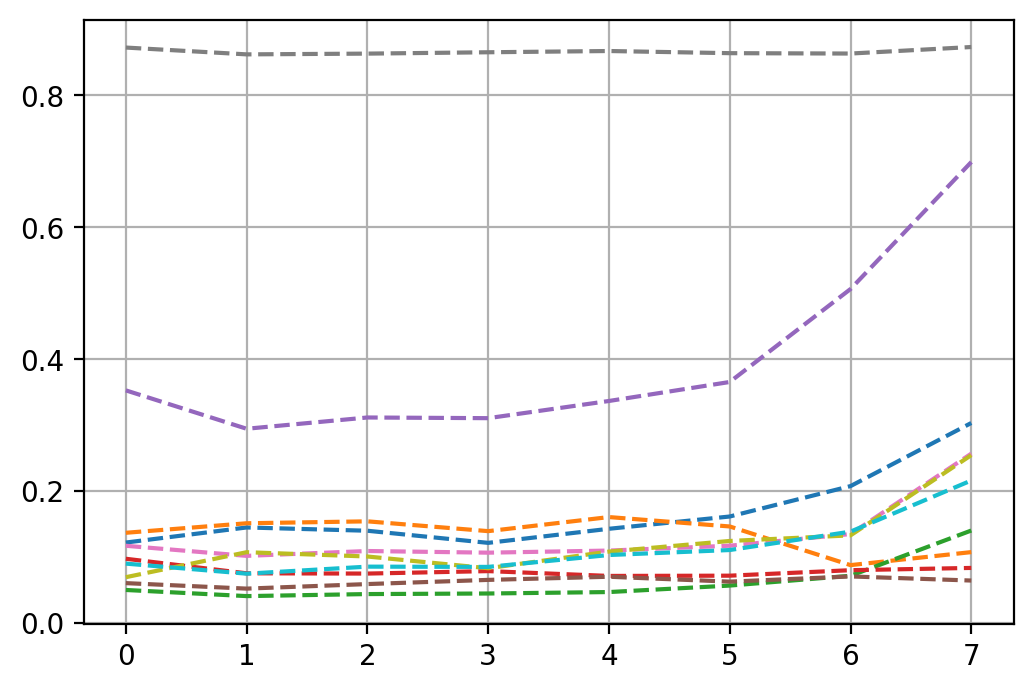

In [194]:
res = []
for i in r_gene[0:10]:
    if i in r_gene:
        res.append(partial_average(data_total[i][0:train_len], np.array(shifted_codes).T[0]))
plot_vec(res)

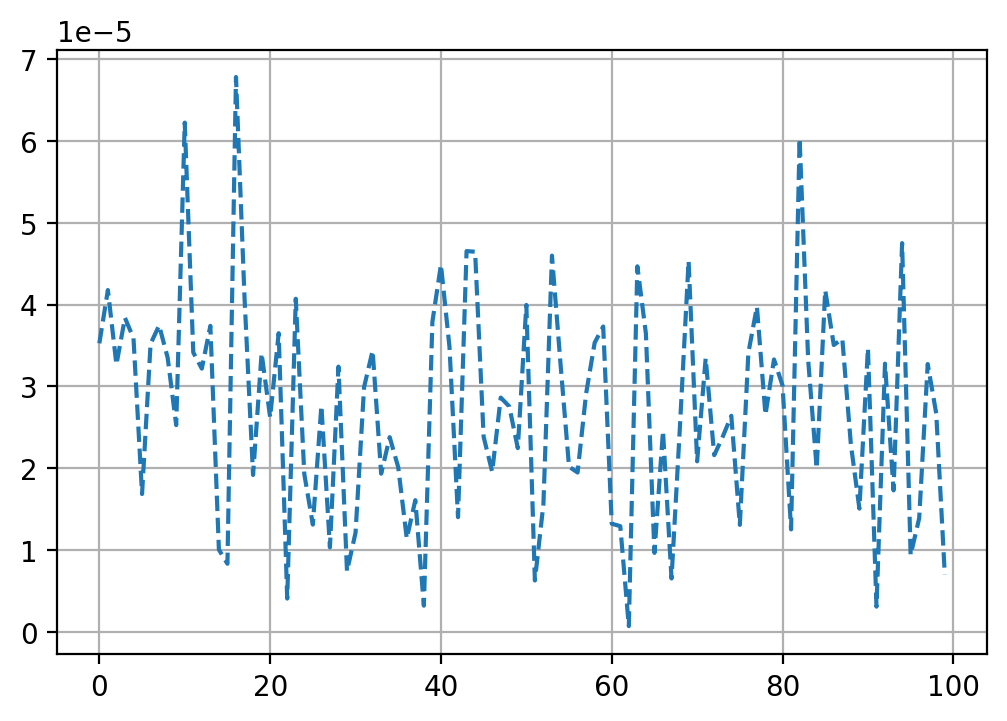

In [199]:
result12 = find_last_reconstruction_error(algo_output12[0], output_mat[:, 0:train_len], algo_output12[1], init_cell_weight)
plot_vec([result8])

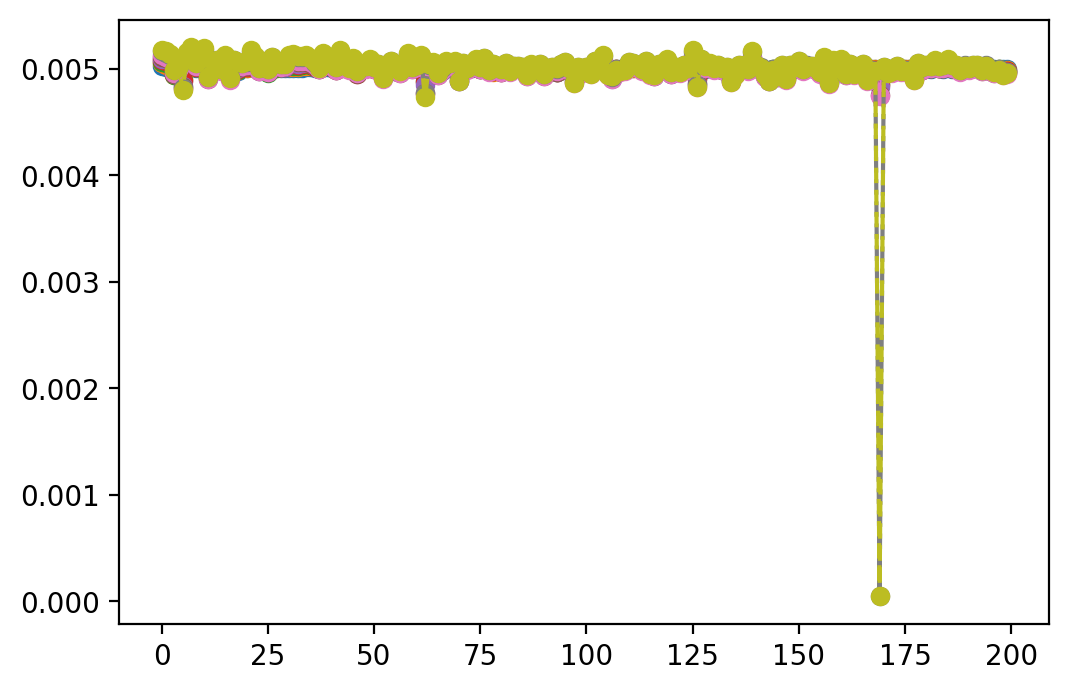

1.0
cur iteration is 9
18010
max_loss is0.9769315226065938


In [ ]:
reload()
# train on a random subset of z_gene + r_gene
cur_list = [(z_gene + r_gene)[i] for i in np.sort(partition[3])]
print(np.sort(partition[0]))
output_mat = dic_to_array(data_total, [cur_list])
output_mat = dataset_gen.normalized_row(output_mat)
# output_mat_norm_log_norm = output_mat.T
# print([index == True])
data_dim, cell_dim = output_mat.shape
max_epoch = 200
code_dim = 1
# hidden_layers = [32, 16]
hidden_layers = [128]
step_size = 0.05
num_iter = 10
train_len = int(cell_dim * 0.98)
print(cell_dim)
print(train_len)
init_weight = 1 * np.array([1/data_dim]*data_dim) + 0 * np.array(([1/len(l_zonated)]*len(l_zonated) + [0] * (data_dim - len(l_zonated))))
init_cell_weight = np.array([1/train_len]*train_len)
# init_weight = np.sum([output_mat >0][0], axis = 1)/ np.sum(np.sum([output_mat >0][0]))
algo_output15 = sudo_algo2.multi_weight_weightedMSE(output_mat, data_dim, max_epoch, code_dim, hidden_layers, step_size, num_iter, init_weight,init_cell_weight, True)



(200,)


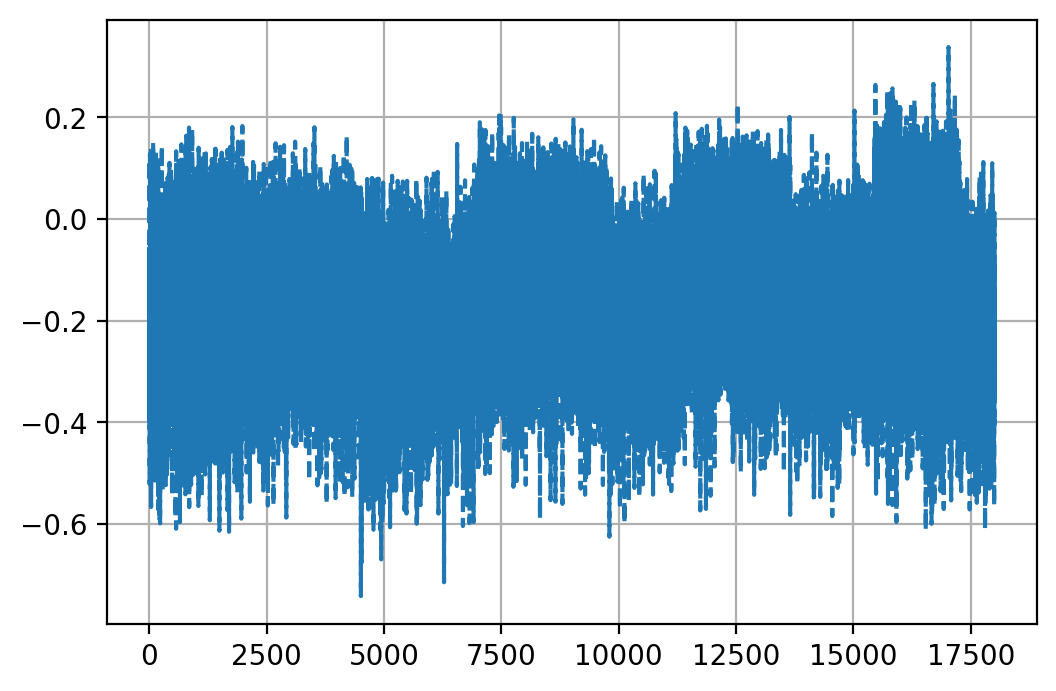

In [207]:
# check encoding of all cells
codes = get_encoder(algo_output15[0], output_mat[:, 0:train_len])
print(np.sort(partition[0]).shape)
plot_vec([np.array(codes)[:, i] for i in range(1)])
# plot_vec([np.array(codes)[i] for i in range(4000)])

here


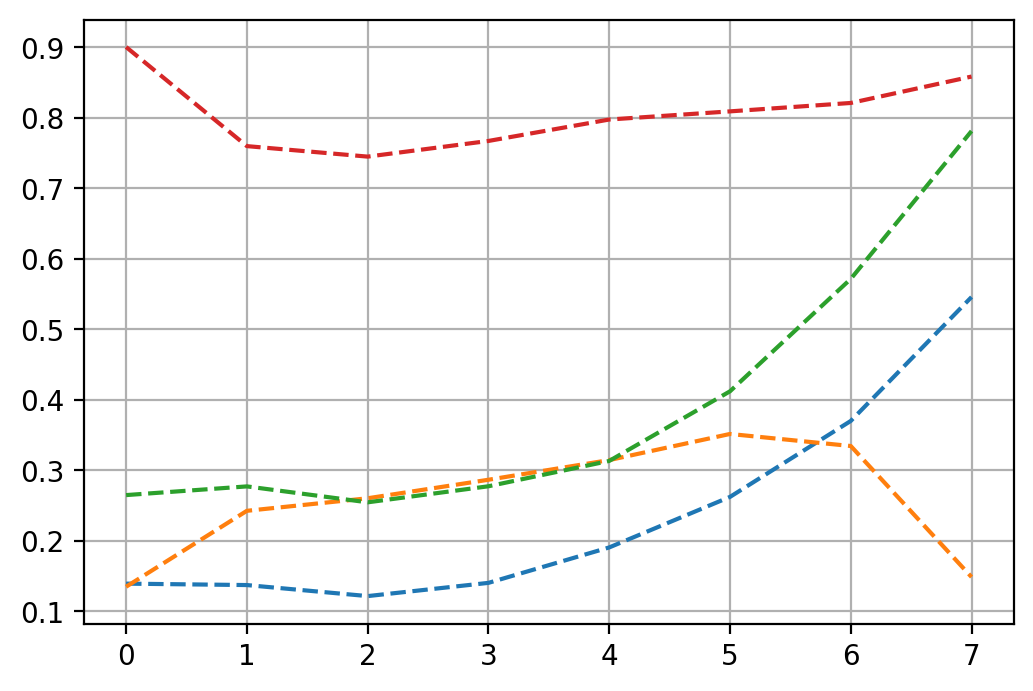

In [210]:
codes = get_encoder(algo_output15[0], output_mat[:, 0:train_len])
shifted_codes = shift(codes, 'none')
res = []
for i in partition[0]:
    if i > 1259 and i < 1275:
        print('here')
        res.append(partial_average(data_total[r_gene[i - 1259]][0:train_len], np.array(shifted_codes).T[0]))
    if i < 20:
        res.append(partial_average(data_total[z_gene[i]][0:train_len], np.array(shifted_codes).T[0]))
    
plot_vec(res)

In [211]:
print(np.sort(partition[3]))

[   6   19   33   35   38   42   58   59   67   82   86   98  105  108
  128  131  151  155  157  165  175  182  184  186  194  200  206  208
  212  218  219  224  226  232  235  238  243  248  260  275  292  294
  300  304  317  318  332  337  349  350  358  367  373  381  383  394
  398  403  417  439  441  443  445  446  459  461  479  487  491  512
  520  527  530  542  548  563  574  587  590  610  611  631  637  653
  654  657  662  664  676  683  687  702  703  706  708  712  731  735
  754  761  763  768  777  797  803  813  816  817  833  843  859  860
  870  884  895  898  907  908  917  923  924  936  937  951  952  953
  955  960  968  973  979  986  992  994  997 1012 1014 1015 1017 1020
 1023 1024 1041 1046 1052 1056 1057 1064 1066 1070 1076 1082 1088 1092
 1100 1107 1111 1115 1123 1134 1149 1154 1155 1156 1158 1160 1171 1172
 1179 1188 1195 1218 1222 1226 1229 1242 1244 1256 1259 1265 1278 1281
 1282 1283 1293 1299 1306 1309 1333 1350 1351 1355 1371 1387 1400 1402
 1403 

(18010,)


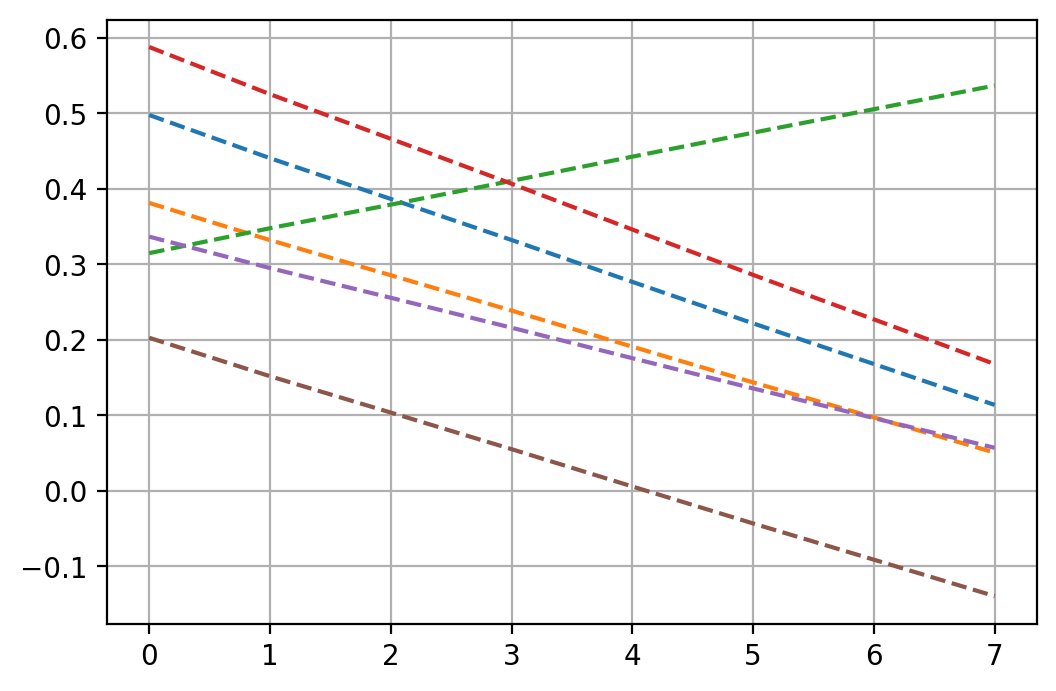

In [182]:
# plot average of reconstruction for some genes based on encoding of cells
# [np.where(data1[g][0] > -22, data1[g][0], np.inf).min() for g in z_gene]
output_mat = dic_to_array(data_total, [cur_list])
outputs = np.array(get_output(algo_output15[0], output_mat[:, 0:train_len]))
print(outputs[:, 0].shape)
res = []
for i in [0, 5, 10, 50, 101, 167]:
#     res.append(data_total[r_gene[i]])
    res.append(partial_average(outputs[:, i][0:train_len], np.array(shifted_codes).T[0]))
#     res.append(outputs[:, i][0:train_len])
plot_vec(res)